# 
# <u><b>0) Pré-requis pour la bonne exécution du Notebook.</b></u>

######  
## <b><u>0.1) Ensemble des variables à modifier en début d'exécution du Notebook, selon l'exploitation qu'on veut en faire.</u></b>
### !!! On attire l'attention du lecteur/utilisateur sur les variables ci dessous :
### <b>- Les chemins d'accès de données :</b> Ils sont définis localement, et depuis peu de façon relative au répertoire contenant ce notebook. Le lecteur/utilisateur est libre de les modifier par rapport à son propre environnement, mais il faudra alors veiller à rendre cette modification cohérence avec le bon accès aux fichiers présents ci-dessous dans les répertoires <b>../Cache_fichiers/</b>, <b>../Figures/</b>, etc.
### <b>- Les booléens d'activation/désactivation :</b> Attention, ces booléens (selon qu'ils prennent True ou False) activent (ou désactivent) des fonctions telles que la sauvegarde en local de fichiers créés à partir de données calculées dans ce notebook, la sauvegarde en local de figures, etc.
### <b>- !!! Le booléen <i>court_circuiter</i> !!! :</b> Attention, c'est le plus important de tous. Il permet d'activer/désactiver les étapes les plus longues en durée de calcul de ce notebbok (calculs de <i>features</i> lors des plongements de mots, optimisation d'hyper-paramètres, etc). SI L'UTILISATEUR TIENT A REFAIRE CES CALCULS, IL FAUT QU'IL SACHE QUE L'EXECUTION TOTALE DE CE NOTEBOOK PEUT PRENDRE 7-8 HEURES DE CALCUL !!! La sauvegarde en local des données calculées dans le <b>/Cache_fichiers/TestModeles/</b> permet de sauter ces étapes longues tout en reprennant les bons résultats de calculs (le hasard est "bloqué" grâce à l'entier <i>rgn</i>=420 (voir plus bas) qui est systématiquement mis en entrée des variables <i>random_state</i> des fonctions qui le proposent).

In [1]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
installation = False

### Tout ce qui concerne la base de donnée
abs_path_cache_input = "../Cache_fichiers/Analyse/V04test_"#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P5/Cache_fichiers/Analyse/V04test_"

### Tout ce qui concerne les figures
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_figure, abs_path_fig = (
    False,
    "../Figures/TestModeles/V04test_",#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P5/Figures/TestModeles/V04test_",
)

### Tout ce qui concerne le cache des fichiers (pour ne pas avoir à refaire tous les calculs systématiquement)
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_fichiers, abs_path_cache_output = (
    True,
    "../Cache_fichiers/TestModeles/V04test_",#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P5/Cache_fichiers/TestModeles/V04test_",
)

### Autres
# Booléens d'activation de la mise de côté des calculs longs, au profit du chargement des résultats de ces calculs, préalablement sauvegardés en local
court_circuiter = True

## <b><u>0.2) Installation de librairies/modules.</u></b>
### !!! Sautez cette étape si vous les avez déjà sur votre ordinateur, en mettant le booléen <i>installation</i> = False !!!

In [2]:
# Installation conditionnée au booléen précédent
if installation:
    ! pip install gensim
    ! pip install tqdm
    ! pip install tensorflow
    ! pip install tensorflow_hub
    ! pip install tensorflow_text
    ! pip install transformers

## <b><u>0.3) Importations de librairies/modules/fonctions déjà existants.</u></b>

In [19]:
### Quelques classiques
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
### Mesure du temps
import tqdm
### Traitement de texte
import re
import gensim
### Scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, train_test_split#, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
### Tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
import tensorflow_hub as hub
import tensorflow_text
import transformers
### pickle, pour sauvegarder en local/charger des données volumineuses calculées avec notebook,et coûteuses en temps de calcul
import pickle

In [4]:
print(tf.__version__)
#print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
Num GPUs Available:  1
True


## <b><u>0.4) Définitions de fonctions personnelles.</u></b>

In [5]:
def identity(input):
    """Fonction indentité, dont la sortie est égale à l`entrée.

    Arguments de cette fonction :
    input -- entrée, quelque soit le type de cette variable"""
    return input

In [6]:
def flatten_serie(serie):
    """Fonction qui `applatit` une série dont chaque élément est une liste,
    en constituant une nouvelle série dont chaque élément est un des objets contenu dans une des listes précédentes.

    Arguments de cette fonction :
    serie -- une pandas.Series, dont les éléments sont des listes d`objets"""
    flattened_serie = pd.Series(np.concatenate((serie.values)))
    return flattened_serie

In [7]:
def intersection_metric(true, pred):
    """Fonction qui calule un score de prédiction, en mesurant le taux de valeurs communes 
    entre une liste de prédictions et une liste de valeurs ciblées par la prédiction.
    Ces valeurs communes sont déterminées grâce à la la fonction numpy.intersect1d().

    Arguments de cette fonction :
    true -- valeurs qu`on cherche à reproduire (nos étiquettes, le plus souvent)
    pred -- valeurs issues de la prédiction, qu'on espèrent les + proche de true"""
    ### Calcul au cas où true est une liste de valeurs, donc de shape=(1,) (de même pour pred)
    if len(np.asarray(true).shape)==1 :
        score = len(np.intersect1d(true, pred))/len(true)
    ### Calcul au cas où true est une liste de liste de valeurs, donc de shape=(nb_lignes,nb_col) (de même pour pred)
    ### Dans ce cas, il s'agira souvent des valeurs d'une pandas.Series
    elif len(np.asarray(true).shape)==2 :
        # cette fois, on retourne la moyenne sur l'ensemble des lignes de la série du score calculé pour chaque ligne
        score = np.mean([len(np.intersect1d(t,p))/len(t) for t,p in zip(true, pred)])
    return score 

In [8]:
def tokens_to_string(list_of_tokens):
    """Fonction qui transforme une liste de tokens (donc une liste de chaînes de carctères)
    en une seule chaîne de caractère, avec un espace entre chaque token

    Arguments de cette fonction :
    list_of_tokens -- liste de chaîne de caractère"""
    # initialisation sur le token d'indice 0
    string = list_of_tokens[0]
    # on parcourt la liste de tokens du 2nd jusqu'à la fin
    for n in range(1,len(list_of_tokens)):
        # on met à jour la variable 'string' en lui rajoutant à la fin un espace et le token n°n+1 (d'indice n, donc)
        string += ' '+list_of_tokens[n]
    return string

In [9]:
def fct_apply(serie, list_lambda_x):
    """Fonction qui permet d`appliquer une série de fonction `lambda x : f(x)`
    à une pandas.Series ou un pandas.Dataframe.

    Arguments de cette fonction :
    serie -- une pandas.Series ou un pandas.Dataframe
    list_lambda_x -- liste de fonction `lambda x : f(x)"""
    # on fait une copie de serie (avec deep=true pour être sûr de protéger l'originale de ces transformation
    output_serie = serie.copy(deep=True)
    # on parcourt la liste des fonctions lambda x
    for lambda_x in list_lambda_x :
        # on met à jour output_serie après chaque application de fonction
        output_serie = output_serie.apply(lambda_x)
    return output_serie

### Ci-dessous, plusieurs fonction DONT JE NE SUIS PAS L'AUTEUR, et qui proviennent du notebook d'analyse de tweet donné en présentation du projet, et dont on nous suggère fortement de s'inspirer (https://openclassrooms.com/fr/paths/148/projects/111/assignment).
### Mes interventions sur ces fonctions sont essentiellement du commentaire (pour m'aider à comprendre comment fonctionnaient certianes parties de certaines fonctions), du regroupement de plusieurs petites fonctions en une seule grosse fonction, et des modifications à la marge.

In [10]:
def fct_w2v_embedding(sentences, maxlen, w2v_size, w2v_window, w2v_min_count, w2v_epochs, lignes_train, lignes_test, no_print):
    """Fonction qui génère des features grâce la technique de plongement de mots nommée word2vec.
    J`ai légèrement modifié cette fonction pour qu`elle retourne les features directement divisées
    entre le jeu d`entraînement et celui de test

    Arguments de cette fonction :
    sentences -- le corpus surlequel va être effectué le plongement de mots, sous forme d`une liste de listes de chaînes de carctères
    maxlen -- la longueur maximale prise par les listes de chaînes de carctères de la variable sentences
    w2v_size -- dimension de l`espace de plongement de mot (et qui sera le nombre de lignes de la matrice de features)
    w2v_window -- taille de la fenêtre utilisée par word2vec pour étudier le contexte autour de chaque mot du corpus
    w2v_min_count -- taille minimale (en nombre de lettres) des tokens à considérer
    w2v_epochs -- nombre d`itérations à répeter sur le corpus lors de l`entraînement 
    lignes_train -- liste des indices correspondant au train set
    lignes_test -- liste des indices correspondant au test set
    no_print -- booléen qui active ou non l`impression de messages"""
    ###### 1) Initialisation du modèle
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window, vector_size=w2v_size, seed=rgn, workers=3)
    # Entraînement
    w2v_model.build_vocab(sentences)#_from_freq(id2word.token2id)#
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    # Vocabulaire
    w2v_words = model_vectors.index_to_key
    if no_print == False :
        print("Vocabulary size: %i" % len(w2v_words))
    ###### 2) Tokenisation
    # Préparation des sentences (tokenization)
    tokenizer = Tokenizer()
    # Façon de regénerer des tokens, même si ça ne fera rien de plus que
    tokenizer.fit_on_texts(sentences)
    # matrice des tokens (ligne = document, colonne = position dans le document, valeur prise = indice du token)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), padding='post')  
    # Nombre de mots uniques trouvés par le tokeniser
    num_words = len(tokenizer.word_index)
    if no_print == False :
        print(f'La matrice x_sentences est de dimensions {x_sentences.shape}, car elle est issue de {sentences.shape} documents, avec au maximum {maxlen} tokens par documents.')
        print("Nombre de mots uniques: %i" % num_words)
    ###### 3) Matrice d'embedding
    ### Initialisation/travqil préparatoire
    # création d'une variable qui contient le dictionnaire {tokens : indice issu de W2V}
    word_index = tokenizer.word_index
    # création d'une variable contenant la taille du vocaculaire (le +1 est sans doute rajouté pour des raisons mathématiques)
    vocab_size = len(word_index) + 1
    # initialisation de la matrice par création d'une matrice de zéros de dimension (taille du vocabulaire, nbr de dimensions réduite de l'espace de plongements de mots)
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    # Initialisation de i et j qui vont servir à mesurer le "taux de plongement de mots" (?)
    i = j = 0
    ### Caclul des éléments de la matrice [plongement effectif des mots]    
    # on parcourt la liste des tokens contenus dans le dictionnaire {tokens : indice issu de W2V}
    for word, idx in word_index.items():
        i +=1
        # Si le mot du dictionnaire est bien contenu dans le vocabulaire du modèle W2V [condition toujours vérifiée tel qu'on a écrit les lignes de codes ci-dessus]
        if word in w2v_words:
            j +=1
            ### On assigne à la ligne correspondant à chaque mot du vocabulaire ses coordonnées réduites dans l'espace de plongement
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
    # Calcul du "taux de plongement de mots"           
    word_rate = np.round(j/i,4)
    del i, j, idx, word, embedding_vector
    if no_print == False :
        print("Taux de plongement de mots : ", word_rate)
        print("Dimensions de la matrice d`embedding : %s" % str(embedding_matrix.shape))
    ##### 4) Application du modèle d'embedding aux données passées par W2V
    input=Input(shape=(len(x_sentences), maxlen), dtype='float64')
    word_input=Input(shape=(maxlen, ), dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size, output_dim=w2v_size, weights = [embedding_matrix], input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input], word_vec)
    if no_print == False :
        embed_model.summary()
    ###### 5) Production des features dans les espaces réduits
    embeddings_train, embeddings_test = embed_model.predict(x_sentences[lignes_train]), embed_model.predict(x_sentences[lignes_test])
    del embed_model, word_vec, word_embedding, word_input, x_sentences, embedding_matrix, tokenizer, num_words, w2v_model, model_vectors
    return embeddings_train, embeddings_test

In [11]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    """Fonction qui tokenise des phrases en amont de la production de features par plongement de mots de type BERT

    Arguments de cette fonction :
    sentences -- le corpus surlequel va être effectué le plongement de mots, sous forme d`une liste de longues chaînes de carctères (pas des tokens)
    bert_tokenizer -- un modèle pour la tokenisation
    max_length -- nombre maximal de mots par chaînes de caractères"""
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    return input_ids, token_type_ids, attention_mask, bert_inp_tot    

In [12]:
# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    """Fonction qui génère des features par plongement de mots de type BERT

    Arguments de cette fonction :
    model -- module python correspondant à modèle pré-entraîné qui va être utilisé 
    model_type -- chaîne de caractère, nom du modèle pré-entraîné
    sentences -- le corpus surlequel va être effectué le plongement de mots, sous forme d`une liste de longues chaînes de carctères (pas des tokens)
    max_length -- nombre maximal de mots par chaînes de caractères
    b_size -- taille du batch
    mode -- chaîne de caractère, soit HF soit TFhub, pour utilser HuggingFace ou Tensorflow Hub"""
    batch_size, batch_size_pred = b_size, b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    #time1 = time.time()
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(
            sentences[idx:idx+batch_size], 
            bert_tokenizer, 
            max_length)
        # Bert HuggingFace
        if mode=='HF' :    
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state
        # Bert Tensorflow Hub
        if mode=='TFhub' : 
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
        # Initialisation si on est au 1er pas du batch
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
        # Sinon, accumulation.
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    ### Lignes supplémenatires, par Luke
    # Si le nombre de documents n'est pas divisible par la taille du batch,
    if (len(sentences)//batch_size)*batch_size != len(sentences) :
        # on re-applique bert_inp_fct sur les derniers documents restants
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(
            sentences[idx+batch_size:], 
            bert_tokenizer, 
            max_length)
        # Bert HuggingFace
        if mode=='HF' :    
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state
        # Bert Tensorflow Hub
        if mode=='TFhub' : 
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
        # Ajout final
        last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    ### Fin des lignes supplémenatires    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    #time2 = np.round(time.time() - time1,0)
    #print("temps traitement : ", time2)
    return features_bert, last_hidden_states_tot

In [13]:
def feature_USE_fct(sentences, b_size) :
    """Fonction qui génère des features par plongement de mots de type USE

    Arguments de cette fonction :
    sentences -- le corpus surlequel va être effectué le plongement de mots, sous forme d`une liste de longues chaînes de carctères (pas des tokens)
    b_size -- taille du batch"""
    batch_size = b_size
    #time1 = time.time()
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])
        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    ### Lignes supplémenatires, par Luke
    ### Si le nombre de documents n'est pas divisible par la taille du batch, on reproduit la boucle précédente sur les documents restants
    if (len(sentences)//batch_size)*batch_size != len(sentences) :
        feat = embed(sentences[idx+batch_size:])
        features = np.concatenate((features,feat))
    ### Fin des lignes supplémenatires    
    #time2 = np.round(time.time() - time1,0)
    return features

### Ci-dessous, on revient à des fonctions personnelle.

In [14]:
def pickle_save(object_to_save, suffix_title):
    """Fonction qui sauvegarde un objet en local grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    object_to_save -- objet python à sauver
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données abs_path_cache_output ait été définie avant"""
    # on ouvre le mode écriture de l'objet à sauvegarder dans le répertoire pointé par abs_path_cache_output
    file_pickel_ab = open(file=abs_path_cache_output+suffix_title,mode='wb')
    # sauvegarde effective
    pickle.dump(object_to_save, file_pickel_ab)
    # fermeture du mode écriture
    file_pickel_ab.close()
    del file_pickel_ab

In [15]:
def pickle_load(suffix_title):
    """Fonction qui charge un objet sauvegardé localement, grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données abs_path_cache_output ait été définie avant"""
    # on ouvre le mode lecture de l'objet rangé dans le répertoire pointé par abs_path_cache_output
    file_pickel_rb = open(file=abs_path_cache_output+suffix_title,mode='rb')
    # chargement effectif
    objet = pickle.load(file_pickel_rb)
    # fermeture du mode lecture
    file_pickel_rb.close()
    del file_pickel_rb
    return objet

In [16]:
def predire_tags_uniques(model, features):
    """Fonction qui assure une prédiction de 5 mots-clefs uniques (partie approche supervisée).

    Arguments de cette fonction :
    model -- modèle de prédiction (type MultiOutputClassifier de sklearn), déjà entraîné 
    features -- features sur lesquels on veut réaliser la prédiction"""
    # initialisation de la liste retournée en sortie de cette fonction
    tab_pred_all_doc = []
    # prédictions correspondant aux features mis en entrée (chaque prédiction = une liste de 5 mots)
    predictions = model.predict(features)
    ### On parcourt les listes de 5 mots prédit
    for i, pred in enumerate(predictions) :
        # liste des mots prédits uniques, et leurs indices dans la liste originale de 5 mots 
        uniques, index = np.unique(pred, return_index=True)
        # si les 5 mots sont déjà uniques, on les range dans la liste qui sera retournée à la fin de cette fonction
        if len(pred) == len(uniques) :
            tab_pred_all_doc.append(pred) 
        # dans le cas contraire (au moins un mot en double)    
        else :
            # on génère les classes que pe prédire le modèle ainsi que les probabilité de prédiction pour chaque classe et par position dans la liste des 5 mots prédit
            classes, probas = model.classes_, model.predict_proba(features)
            # initialisation d'une nouvelle liste de 5 mots-prédits
            nouv_pred = ['', '', '', '', '']
            # pour chaque indice corrspondant à un mot unique dans la liste originale, on met sa valeur à la place de '' dans nouv_pred
            for n in index :
                if nouv_pred[n] == '':
                    nouv_pred[n] = uniques[index==n][0]
            # maintenant on parcourt la liste nouv_pred
            for n in range(5):
                # si il y a toujours '' à l'indice n (ce qui signifie qu'il y avait un mot non unique à remplacer dans la liste originale)
                if nouv_pred[n] == '' :
                    ### on parcourt la liste des 5 prédictions les + probables correspondant à cette position dans la liste, jusqu'à trouver une prédiction authentiquement nouvelle
                    possibilites = classes[n][np.argsort(probas[n][i])[-1:-6:-1]]
                    j, tag = 0, possibilites[0]
                    while tag in nouv_pred :#uniques :
                        j +=1
                        tag = possibilites[j]
                    nouv_pred[n]= tag
            tab_pred_all_doc.append(nouv_pred)
            del nouv_pred, classes, probas, n, possibilites, j, tag
        del uniques, index
    del i, pred
    return tab_pred_all_doc

## <b><u>0.5) Définitions de constantes personnelles.</u></b>

In [17]:
# Random State fixé une bonne fois pour toute
rgn = 420

In [18]:
os.environ["TF_KERAS"]='1'

# 
# <b><u>I) Données de travail.</u></b>
### Les données de travail sont toutes issues du notebook précédent, dédié à l'analyse et au nettoyage de la base de données. Elles ont été sauvegardées dans un repertoire local, dont le chemin d'accès est donné en section <b>0.1</b> sous la variable <i>abs_path_cache_input</i>.

######  
## <b><u>I.1) Données necessaires pour l'approche <i>Bag of Words</i>.</u></b>
### On charge les données issues de l'approche BOW produites dans le notebook précédent (en particulier : la pandas.Series des tokens créée à l'issue de la phase de nettoyage).

In [20]:
serie_tokensnet = pd.read_csv(abs_path_cache_input + 'serie_titlenet.csv', index_col=0)
# On reproduit correctement les listes de tokens
serie_tokensnet = pd.Series(data=[re.split(string=x[2:-2], pattern='\', \'') for x in serie_tokensnet.values.reshape(-1)],
                         index=serie_tokensnet.index, 
                         name=serie_tokensnet.columns[0])
# Affichage de contrôle
serie_tokensnet#.loc[serie_tokens.index[np.random.randint(0, len(serie_tokens), len(serie_tokens)//2)]]

2                                 [linq, query, datatable]
3                                    [overload, std, swap]
4                                  [directory, listing, c]
5                        [returning, datatables, wcf, net]
6         [datetime, best, measure, function, performance]
                               ...                        
27120          [select, row, panda, multiindex, dataframe]
27121    [suspend, function, callgetapi, called, corout...
27123    [perform, react, state, update, unmounted, com...
27124      [wpf, application, run, linux, mac, .net, core]
27126              [none, eq, seem, evaluate, true, quite]
Name: Title tokens sw lem, Length: 13558, dtype: object

### On en profite pour créer une pandas.Series contenant les fréquences d'apparitions de chacun des terme du vocabulaire des tokens.

In [21]:
freq_app = flatten_serie(serie_tokensnet).value_counts()

### On charge également la liste des mots-clefs tokenisés réalisées dans le notebook précédent.

In [22]:
# Série de tags
serie_tags = pd.read_csv(abs_path_cache_input + 'serie_tags.csv', index_col=0)
#On reproduit correctement les listes de tokens
serie_tags = pd.Series(data=[re.split(string=x[2:-2], pattern='\', \'') for x in serie_tags.values.reshape(-1)],
                         index=serie_tags.index, 
                         name=serie_tags.columns[0])
#On prend les mêmes indices que pour les tokens.
serie_tags = serie_tags.loc[serie_tokensnet.index]
# Affichage
serie_tags

2                    [c#, .net, linq, datatable, .net-3.5]
3           [c++, performance, optimization, stl, c++-faq]
4        [c, file, directory, cross-platform, common-ta...
5                 [c#, .net, wcf, web-services, datatable]
6                 [c#, .net, performance, datetime, timer]
                               ...                        
27120      [python, pandas, dataframe, slice, multi-index]
27121    [android, kotlin, kotlin-coroutines, coroutine...
27123    [javascript, reactjs, typescript, lodash, sets...
27124    [linux, wpf, .net-core, desktop-application, ....
27126    [python, python-3.x, string, boolean-expressio...
Name: Tags tokens, Length: 13558, dtype: object

### On vérifie qu'elle soit bien constituée de 5 mots-clefs par documents :

In [23]:
serie_tags.apply(lambda x : len(x)).value_counts()

5    13558
Name: Tags tokens, dtype: int64

### Et on détermine l'ensemble des mots-clefs présents parmis les tokens :

In [24]:
tags_in_tokens = np.intersect1d(flatten_serie(serie_tags).unique(), flatten_serie(serie_tokensnet).unique())
print(f'Il y a {len(tags_in_tokens)} mots-clefs présents parmis les tokens, sur :')
print(f'- {len(flatten_serie(serie_tags).unique())} mots-clefs ({100*len(tags_in_tokens)/len(flatten_serie(serie_tags).unique()):.0f}%)')
print(f'- {len(flatten_serie(serie_tokensnet).unique())} tokens ({100*len(tags_in_tokens)/len(flatten_serie(serie_tokensnet).unique()):.0f}%)')

Il y a 3071 mots-clefs présents parmis les tokens, sur :
- 8457 mots-clefs (36%)
- 8305 tokens (37%)


######  
## <b><u>I.2) Création de jeux d'entraînement et de test.</u></b>

### On prend une proportion de jeu d'entraînement relativement peu élevée (par rapport à d'habitude où 0.8,0.9 serait un peu plus usuel) pour conduire à un jeu d'entraînement de moins de 10000 documents, ce qui devrait limiter les temps d'entraînements des différents modèles de l'approche supervisée à ~1h maximum.
### La séparation se fait selon les indices de la série issue de Tags.

In [25]:
indx_train, indx_test = train_test_split(serie_tags.index, test_size=0.3, random_state=rgn)
print(f'Taille jeu d`entraînement : {indx_train.shape[0]},\nTaille jeu de test : {indx_test.shape[0]}')

Taille jeu d`entraînement : 9490,
Taille jeu de test : 4068


### Le train_test_split ne conservant pas l'ordre des indices, on calcule quelles sont les lignes [soit les numéros de documents] qui correspondent à chaque élément des deux tableaux d'indices précédents. Cela nous permettra de diviser les matrices de features en matrices d'entraînement et de test, selon les lignes, en respectant la séparation effectuée par train_test_split.

In [26]:
lignes_train = np.array([np.argwhere(serie_tags.index.values==ind) for ind in indx_train]).reshape(len(indx_train))
lignes_test = np.array([np.argwhere(serie_tags.index.values==ind) for ind in indx_test]).reshape(len(indx_test))

######  
## <b><u>II.1) LDA sur les corpus de <i>Title</i>.</u></b>

######  
### Notre démarche s'inspire de ce qu'on a trouvé au sein de diverses ressources du projet. En l'occurrence, on pense en particulier à https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0.

###### 
### <b><u>II.1.a) Génération du BOW (TF puis TF-IDF) :</u></b>

In [27]:
### Création d'un BOW
# initialisation d'un dictionnaire gensim adapté au corpus
id2word = gensim.corpora.Dictionary(serie_tokensnet.values)
# création effective du BOW
bow = [id2word.doc2bow(list_tokens) for list_tokens in serie_tokensnet.values]

In [28]:
### Création BOW passé par tdidf
# initialisation
model_tdidf = gensim.models.TfidfModel(bow, id2word)
# création du BOW pondéré par l'idf
bow_idf = model_tdidf[bow]

### On entraîne deux 1ers modèles de LDA à partir de ces deux BOW, et on affiche les mots les plus probables associés aux thèmes inférés dans les deux cas.
### D'abord avec le BOW TF :

In [29]:
### Construiction d'un modèle de LDA basé sur le BOW
lda_model = gensim.models.LdaMulticore(corpus=bow, id2word=id2word, num_topics=10, random_state=rgn, chunksize=100, passes=10, per_word_topics=True)
# Impression de la liste des "top-words" associés à chaque topics inférés
lda_model.print_topics()

[(0,
  '0.026*"studio" + 0.019*"visual" + 0.018*"install" + 0.015*"std" + 0.015*"test" + 0.013*"python" + 0.011*"window" + 0.010*"path" + 0.010*"package" + 0.010*"thread"'),
 (1,
  '0.076*"file" + 0.018*"line" + 0.018*"command" + 0.014*"find" + 0.014*"color" + 0.013*"git" + 0.012*"spring" + 0.012*"window" + 0.012*"directory" + 0.009*"text"'),
 (2,
  '0.013*"resource" + 0.012*"update" + 0.012*"server" + 0.011*"data" + 0.011*"instead" + 0.010*"npm" + 0.010*"sql" + 0.010*"error" + 0.010*"case" + 0.009*"need"'),
 (3,
  '0.044*"v" + 0.025*"c" + 0.018*"type" + 0.017*"object" + 0.017*"column" + 0.017*"array" + 0.015*"list" + 0.015*"string" + 0.014*"java" + 0.013*"class"'),
 (4,
  '0.023*"http" + 0.023*"error" + 0.015*"request" + 0.013*"framework" + 0.011*"header" + 0.011*"access" + 0.009*"entity" + 0.009*"user" + 0.008*"server" + 0.008*"post"'),
 (5,
  '0.016*"angular" + 0.013*"work" + 0.012*"j" + 0.011*"authentication" + 0.011*"character" + 0.010*"json" + 0.010*"async" + 0.009*"node" + 0.009

### Puis avec le BOW pondéré (TF-IDF):

In [30]:
### Construiction d'un modèle de LDA basé sur le BOW tdidf
lda_model_idf = gensim.models.LdaMulticore(corpus=bow_idf, id2word=id2word, num_topics=10, random_state=rgn, chunksize=100, passes=10, per_word_topics=True)
# Impression de la liste des "top-words" associés à chaque topics inférés
lda_model_idf.print_topics()

[(0,
  '0.014*"studio" + 0.011*"visual" + 0.009*"install" + 0.007*"app" + 0.007*"path" + 0.007*"android" + 0.007*"found" + 0.006*"error" + 0.006*"build" + 0.006*"file"'),
 (1,
  '0.008*"j" + 0.008*"file" + 0.007*"node.js" + 0.007*"node" + 0.006*"web" + 0.005*"docker" + 0.005*"container" + 0.005*"download" + 0.004*"authentication" + 0.004*"device"'),
 (2,
  '0.008*"inside" + 0.008*"github" + 0.007*"git" + 0.007*"statement" + 0.007*"update" + 0.006*"npm" + 0.006*"dependency" + 0.006*"need" + 0.006*"repository" + 0.006*"import"'),
 (3,
  '0.011*"object" + 0.008*"class" + 0.007*"c" + 0.007*"type" + 0.007*"post" + 0.007*"swift" + 0.006*"static" + 0.006*"array" + 0.006*"return" + 0.006*"method"'),
 (4,
  '0.008*"column" + 0.006*"postgresql" + 0.006*"string" + 0.006*"check" + 0.005*"http" + 0.005*"error" + 0.005*"server" + 0.005*"spring" + 0.005*"value" + 0.005*"header"'),
 (5,
  '0.009*"r" + 0.008*"angular" + 0.008*"fragment" + 0.008*"layout" + 0.007*"point" + 0.007*"prevent" + 0.007*"cache"

### Si c'est lignes permettent de se faire un peu la main sur toutes ces fonctions issues du module de gensim, en revanche, on a dû souvent mal à trouver un sujet global pour chacun de ces thèmes à la seule lecture des 10 mots les plus probables qui leurs sont associés. On voit d'ailleurs que certains mots, comme <i>python</i> sont présents dans plusieurs thème, ce qui n'arrange pas nos affaires pour interpréter 10 thèmes différents...

###### 
### <b><u>II.1.b) Utilisation du score de cohérence en guise de métrique :</u></b>

### Toujours par inspiration prise sur le notebbok cité plus haut (https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0), on décide d'utiliser une métrique pour nous aider à travailler et faire des choix. Testons ainsi la métrique de cohérence c_v, en calculant les scores de cohérences des 10 thèmes inférés par les deux modèles différents : 

In [31]:
coh_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=serie_tokensnet.values, dictionary=id2word, coherence='c_v')
print('Pour le modèle LDA entraîné sur le BOW-tf :\n')
print(f'Le score de cohérence c_v en moyenne sur l`ensemble des topics est de {coh_model_lda.get_coherence() : .2f}')
print(f'Pour chaque topics pris individuellement, les scores sont les suivants :{[np.around(score,2) for score in coh_model_lda.get_coherence_per_topic()]}\n')
coh_model_lda_idf = gensim.models.CoherenceModel(model=lda_model_idf, texts=serie_tokensnet.values, dictionary=id2word, coherence='c_v')#.get_coherence()
print('\nPour le modèle LDA entraîné sur le BOW-tfidf :\n')
print(f'Le score de cohérence c_v en moyenne sur l`ensemble des topics est de {coh_model_lda_idf.get_coherence() : .2f}')
print(f'Pour chaque topics pris individuellement, les scores sont les suivants :{[np.around(score,2) for score in coh_model_lda_idf.get_coherence_per_topic()]}')

Pour le modèle LDA entraîné sur le BOW-tf :

Le score de cohérence c_v en moyenne sur l`ensemble des topics est de  0.37
Pour chaque topics pris individuellement, les scores sont les suivants :[0.38, 0.3, 0.44, 0.23, 0.34, 0.49, 0.45, 0.39, 0.37, 0.35]


Pour le modèle LDA entraîné sur le BOW-tfidf :

Le score de cohérence c_v en moyenne sur l`ensemble des topics est de  0.47
Pour chaque topics pris individuellement, les scores sont les suivants :[0.41, 0.49, 0.59, 0.33, 0.41, 0.71, 0.38, 0.53, 0.47, 0.38]


### Nettement mieux avec tf-idf, c'est pour nous la preuve que td-idf est + intéressant que tf.

In [32]:
# On efface du coup les variables issues du BOW tf
if court_circuiter == False :
    del coh_model_lda, lda_model, bow

###### 
### <b><u>II.1.c) Optimisation "manuelle" des hyper-paramètres du modèle LDA.</u></b>

### Bien, on va continuer à utiliser cette métrique, mais cette fois pour optimiser les hyper-paramètres de la LDA :
- nombre de sujets
- alpha (paramètre scalaire pour la distribution de mots par sujets)
- eta (paramètre scalaire pour la distribution de sujets par documents).
### On ne touche pas aux autres paramètres tels que <i>chuncksize</i>, car ces paramètres ont d'avantage d'impact sur la durée du calcul que sur la valeur du résultat.

### Notons que d'après la notice de la fonction <i>gensim.models.LdaMulticore</i>, on a :
- "symmetric" = 1/(nombre de sujets)
- "asymmetric" = 1/( racine carrée du ombre de sujets + indice du sujet courrant )
### (Il faudra donc peut-être) calculer manuellement les valeurs correspondantes lors des étapes suivantes.

In [33]:
if court_circuiter == False :
    #def optimiser_hyperparam_lda(corpus, texts, dictionary, topics_range=, alphas)
    corpus = bow_idf#gensim.utils.ClippedCorpus(bow_idf, int(len(bow_idf)*0.1))
    texts = serie_tokensnet.values
    dictionary = id2word 
    # Topics range
    topics_range = range(2, 15, 2)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')
    model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
    # iterate through number of topics
    pbar = tqdm.tqdm(total=len(topics_range))
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha=a, eta=b, random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
                cv = gensim.models.CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
        pbar.update(1)
    df_opt_lda_01 = pd.DataFrame(model_results)
    del k, a, b, cv, lda, topics_range, alpha, beta, corpus, dictionary, texts, pbar, model_results
    # Sauvegarde en local dans le cache
    if sauvegarde_fichiers :
        df_opt_lda_01.to_csv(abs_path_cache_output + 'nonsupervise_01_optimisation_hyper_param_lda_tdfidf.csv')
else :
    df_opt_lda_01 = pd.read_csv(abs_path_cache_output + 'nonsupervise_01_optimisation_hyper_param_lda_tdfidf.csv', index_col=0)

In [34]:
# Affichage
df_opt_lda_01

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.255915
1,2,0.01,0.31,0.246285
2,2,0.01,0.61,0.241791
3,2,0.01,0.9099999999999999,0.246680
4,2,0.01,symmetric,0.225049
...,...,...,...,...
205,14,asymmetric,0.01,0.494664
206,14,asymmetric,0.31,0.533817
207,14,asymmetric,0.61,0.482360
208,14,asymmetric,0.9099999999999999,0.430346


### Quelle est la meilleure combinaison d'hyper_paramètres ?

In [35]:
# Regroupement du Dataframe selon les hyper_paramètres, et description statistique (la moyenne suffit car il n'y a qu'un caclul de cohérence par trio ('Alpha','Beta','Topics'))
scores = df_opt_lda_01.groupby(['Alpha','Beta','Topics']).describe(percentiles=[0.5])[('Coherence','mean')]
# Affichage de la combinaison conduisant au meilleur score
scores[scores == scores.max()]

Alpha       Beta  Topics
asymmetric  0.31  8         0.631837
Name: (Coherence, mean), dtype: float64

### Soulagement qu'on ne soit pas à 14 sujets, car cela signifie qu'il n'y a pas accroissement monotone du score avec le nombre de sujets.
### Au cas où, donnons nous une idée de la variation du score en fonction de chacun des hyper-paramètres :

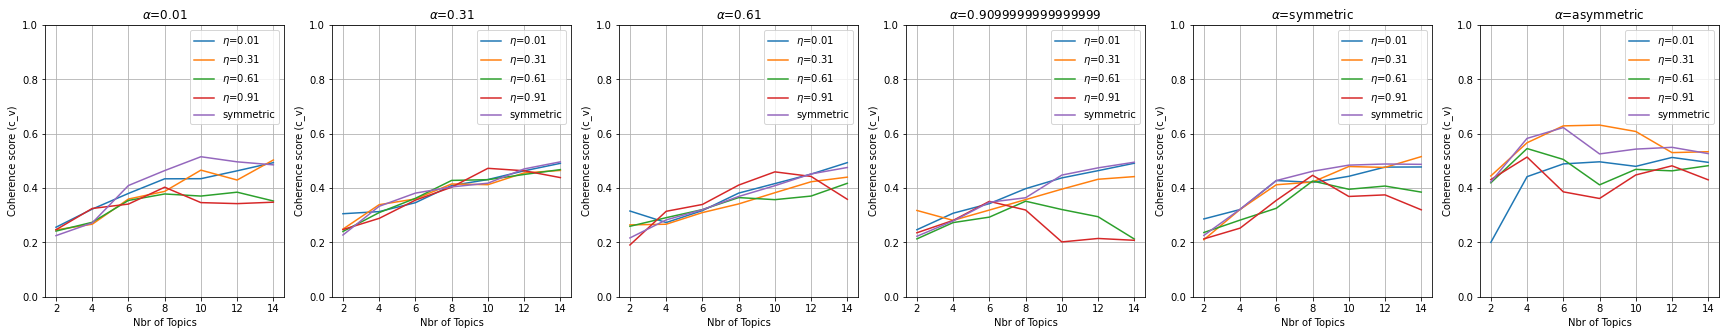

In [36]:
plt.figure('Cohenrence en fonction du nombre de sujet, par valeurs de alpha et eta', figsize=(30,5)), plt.clf()
alphas, betas = df_opt_lda_01['Alpha'].unique(), df_opt_lda_01['Beta'].unique()
for a in alphas :
    i = np.argwhere(alphas==a)[0,0]
    axe, df_plot = plt.subplot(1, len(alphas), i+1), df_opt_lda_01[df_opt_lda_01['Alpha']==a]
    axe.set_title(r'$\alpha$='+str(a)), axe.set_xlabel('Nbr of Topics'), axe.set_ylabel('Coherence score (c_v)')
    for b in betas :
        label_b = f'$\eta$={float(b):.2f}' if b != 'symmetric' else b
        df_plot_2 = df_plot[df_plot['Beta']==b]
        axe.plot(df_plot_2['Topics'], df_plot_2['Coherence'], label=label_b)
    axe.legend(loc='best'), axe.set_ylim([0,1]), axe.grid(which='both')
del a, alphas, b, betas, axe, label_b, df_plot, df_plot_2

### Globalement, coherence augmente avec nb de sujets, mais on voit que la combinaison des valeurs de alpha et eta peut donner des variations importantes, et qu'on a jamais de la monotonie. Il faut donc faire attention, et toujours prendre ces valeurs avec prudence.

###### 
### <b><u>II.1.d) Analyse du modèles avec hyper-paramètres optimaux :</u></b>

### On met à jour le modèle avec les hyper-paramètres optimaux :

In [37]:
# liste des hyper-paramètres optimisés
hyper_p = [float(p) if (p!='symmetric')&(p!='asymmetric') else p for p in scores[scores == scores.max()].index.values[0]]
# Construiction d'un modèle de LDA basé sur le BOW tdidf
lda_model_idf_opt = gensim.models.LdaMulticore(corpus=bow_idf, id2word=id2word, num_topics=hyper_p[2], alpha=hyper_p[0], eta=hyper_p[1], random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
# Top words per topics, topics classé selon le score de coherence c_v
top_topics = lda_model_idf_opt.top_topics(corpus=bow_idf, texts=serie_tokensnet.values, dictionary=id2word, coherence='c_v')

### Et on trace, en bleu, l'évolution de la fréquence moyenne d'apparition des <i>top words</i> de chaque thème en fonction du thème (représentés en abscice par - justement - une liste de quelques <i>top words</i>). On notera que l'écart-type de fréquence d'apparition est représenté sous la forme de barre d'erreur.
### On trace sur la même figure la valeur du score moyen de cohérence de chacun de ces thème (courbe rouge).

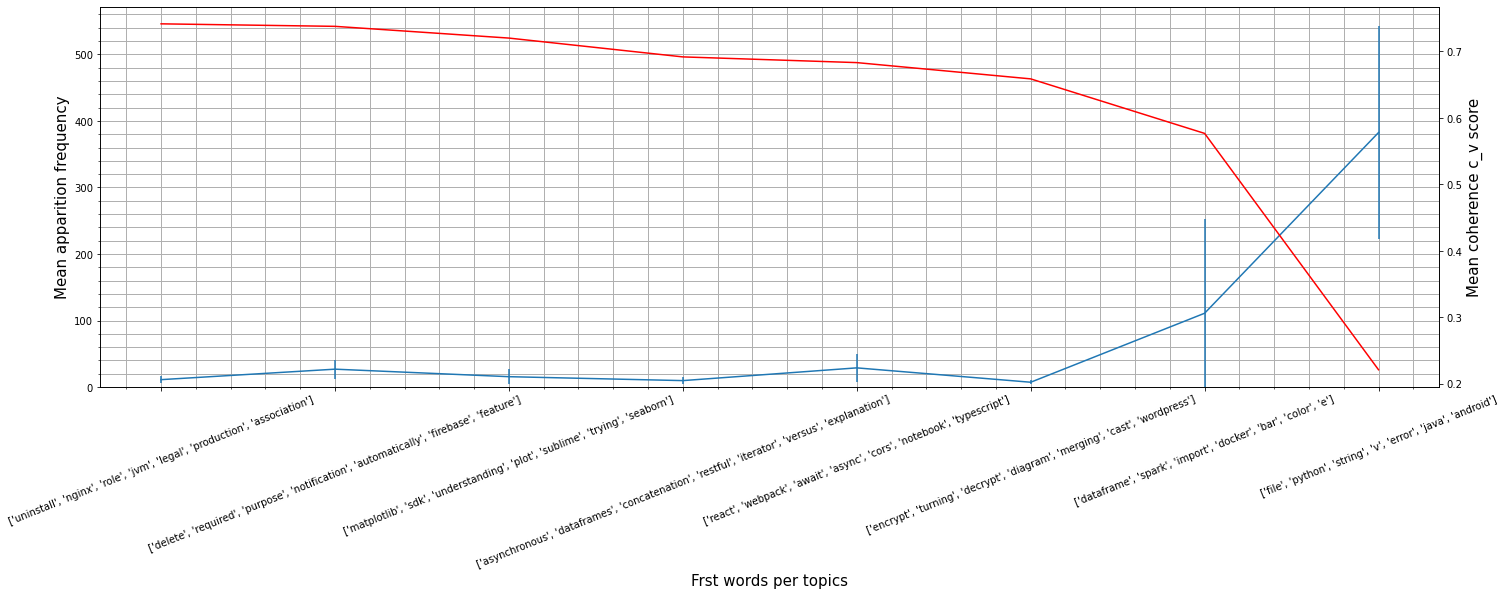

In [38]:
plt.figure('Frequence apparition = errorbar(topics)', figsize=(24,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_xlabel('Frst words per topics', fontsize=15)
axe.set_ylabel('Mean apparition frequency', fontsize=15)
axe.errorbar(x=range(int(hyper_p[2])),
             y=[freq_app[np.array(topic[0])[:,1]].mean() for topic in top_topics], 
             yerr=[freq_app[np.array(topic[0])[:,1]].std() for topic in top_topics])
axe.set_xticks(range(int(hyper_p[2]))), axe.set_xticklabels([list(np.array(topic[0])[:6,1]) for topic in top_topics], rotation=22)
axe.grid(which='both', linewidth=1), axe.minorticks_on(), axe.set_ylim(ymin=0)
axe2 = axe.twinx()
axe2.set_ylabel('Mean coherence c_v score', fontsize=15)
axe2.plot(range(int(hyper_p[2])),
          [topic[1] for topic in top_topics], color='red')
axe2.set_xticks(range(int(hyper_p[2]))), axe2.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics], rotation=22)
del axe, axe2

### Il semble y avoir une corrélation négative entre cohérence du thème et fréquence d'apparition de ces <i>top words</i>, ce qui n'est pas forcément illogique d'ailleurs. Le dernier sujet est à ce titre probablement constitué de mots parmis les plus fréquents du corpus de texte
### Pour le reste, il est difficile de donner explicitement un titre global à chaque thème, à la vue des ses mots les plus probables. 
### Affichons explicitement les top-words de chaque thème :

In [39]:
df_info_topics = pd.DataFrame(
    data={
    f'Topic n°{i}': [id2word.id2token[n] for n in np.asarray(lda_model_idf_opt.get_topic_terms(i))[:,0]] for i in range(int(hyper_p[2]))
}, 
    index=[f'Top word n°{i}' for i in range(len(lda_model_idf_opt.get_topic_terms(0)))]
)
# Affichage 
df_info_topics

,Topic n°0,Topic n°1,Topic n°2,Topic n°3,Topic n°4,Topic n°5,Topic n°6,Topic n°7
Top word n°0,file,dataframe,delete,react,uninstall,matplotlib,encrypt,asynchronous
Top word n°1,python,spark,required,webpack,nginx,sdk,turning,dataframes
Top word n°2,string,import,purpose,await,role,understanding,decrypt,concatenation
Top word n°3,v,docker,notification,async,jvm,plot,diagram,restful
Top word n°4,error,bar,automatically,cors,legal,sublime,merging,iterator
Top word n°5,java,color,firebase,notebook,production,trying,cast,versus
Top word n°6,android,e,feature,typescript,association,seaborn,wordpress,explanation
Top word n°7,function,container,loaded,jupyter,effect,eslint,uml,volume
Top word n°8,value,navigation,virtualenv,exactly,aggregation,anaconda,upstream,modern
Top word n°9,array,scala,fit,babel,intent,uiimageview,negative,gulp


### Effectivement, on a bien quelques mots qui, associés au sein d'un même thème, on du sens, comme par exemple :
- topic 2 : notebook et jupyter ;
- topic 5 : matplotlib et plot et seaborn ;
- topic 6 : encrypt et decrypt...
### Mais on n'arrive pas à aller plus loin que ça et trouver plus de sens commun à chaque paquet 10 mots...

### Si on regarde la répartition des documents par thème (en attribuant à chaque document son thème le plus probable) :

In [40]:
doc_topic_distrib = np.asarray(lda_model_idf_opt.get_document_topics(bow_idf))
# Nombre de documents associé à chaque topics le plus probable :
topics_per_doc = pd.DataFrame(data={'1st most likely topic':np.argmax(doc_topic_distrib[:,:,1], axis=1)}, 
                              index=serie_tokensnet.index)
# Affichage
topics_per_doc.value_counts()

1st most likely topic
0                        10962
1                         1132
2                          531
3                          353
4                          194
5                          187
6                          104
7                           95
dtype: int64

### On se rend compte que les thèmes 0 et 1 (qui sont ceux constitués de top-words les + fréquents) contiennent l'écrasante majorité des mots du corpus. C'est très insatisfaisant.

###### 
### <u><b>II.1.e) En réduisant le BOW TF-IDF aux mots présents plus de 50 fois.</b></u>

### On a vue que la plupart des topics sont constitués de mots de fréquence d'apparition assez "basse" par rapport à celles des mots des deux sujets majoritaires (fréquence moyenne < 40 pour 8 topics/10 reprséentant au total moins de 1500 documents sur près de 13000). On décide donc de relancer notre modèle, mais en veillant d'abord à supprimer du corpus de title tous les mots de fréquence < 50 !!! En espérant que celà conduira à une meilleure répartition des mots par document, et à interpréter + facilement le sujet global de chaque topic.

In [41]:
freq_app[freq_app>=50].sum(), flatten_serie(serie_tokensnet).shape[0]

(38013, 75162)

### Ci-dessus, les mots de fréquence d'apparition >=50 représentent tout de même un peu plus de la moitié des mots du corpus de <i>Title</i> (en terme de nombre total de mots), la plupart des documents en contiennent sûrement au moins 1.
### D'ailleurs, on est obligé de recréer un corpus cne contenant plus que les mots de fréquence >= 50, et d'en éliminer les documents ainsi vidés :

In [42]:
# on élimine les mots de fréquence < 50
serie_tokensnet_sup = serie_tokensnet.apply(lambda x : [w for w in x if freq_app[w]>=50])
# on élimine les documents vides
serie_tokensnet_sup = serie_tokensnet_sup[serie_tokensnet_sup.apply(lambda x : len(x)>0)]
# Affichage :
serie_tokensnet_sup

2                                            [linq, query]
3                                                    [std]
4                                           [directory, c]
5                                                    [net]
6                  [datetime, best, function, performance]
                               ...                        
27117    [error, page, error, cannot, determine, selenium]
27120                      [select, row, panda, dataframe]
27121                        [function, another, function]
27123                           [react, update, component]
27124      [wpf, application, run, linux, mac, .net, core]
Name: Title tokens sw lem, Length: 12747, dtype: object

### (On a donc totalement vidé moins de 1000 document sur plus de 13000 initialement, ça peut aller).
### On recrée un BOW TF-IDF à partir de ce nouveaucorpus, et on re-entraîne un modèle de LDA sur ce même nouveau corpus.

In [43]:
### Création d'un BOW
# initialisation d'un dictionnaire gensim adapté au corpus
id2word_sup = gensim.corpora.Dictionary(serie_tokensnet_sup.values)
# création effective du BOW
bow_sup = [id2word_sup.doc2bow(list_tokens) for list_tokens in serie_tokensnet_sup.values]
### Création BOW passé par tdidf
# initialisation
model_tdidf_sup = gensim.models.TfidfModel(bow_sup, id2word_sup)
# création du BOW pondéré par l'idf
bow_idf_sup = model_tdidf_sup[bow_sup]

### On doit formellement repasser par de la ré-optimisation des mêmes hyper-paramètres :

In [44]:
if court_circuiter == False :#1==1:#
    #def optimiser_hyperparam_lda(corpus, texts, dictionary, topics_range=, alphas)
    corpus = bow_idf_sup#gensim.utils.ClippedCorpus(bow_idf, int(len(bow_idf)*0.1))
    texts = serie_tokensnet_sup.values
    dictionary = id2word_sup 
    # Topics range
    topics_range = range(2, 15, 2)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')
    model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
    # iterate through number of topics
    pbar = tqdm.tqdm(total=len(topics_range))
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha=a, eta=b, random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
                cv = gensim.models.CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
        pbar.update(1)
    df_opt_lda_01_sup = pd.DataFrame(model_results)
    del k, a, b, cv, lda, topics_range, alpha, beta, corpus, dictionary, texts, pbar, model_results
    # Sauvegarde en local dans le cache
    if sauvegarde_fichiers :
        df_opt_lda_01_sup.to_csv(abs_path_cache_output + 'nonsupervise_01_optimisation_hyper_param_lda_tdfidf_sup.csv')
else :
    df_opt_lda_01_sup = pd.read_csv(abs_path_cache_output + 'nonsupervise_01_optimisation_hyper_param_lda_tdfidf_sup.csv', index_col=0)

In [45]:
#df_opt_lda_02.to_csv(abs_path_cache_output + 'nonsupervise_02_optimisation_hyper_param_lda_tdfidf_solalt.csv')
df_opt_lda_01_sup

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.258877
1,2,0.01,0.31,0.287770
2,2,0.01,0.61,0.264088
3,2,0.01,0.9099999999999999,0.204574
4,2,0.01,symmetric,0.226881
...,...,...,...,...
205,14,asymmetric,0.01,0.497726
206,14,asymmetric,0.31,0.412524
207,14,asymmetric,0.61,0.400140
208,14,asymmetric,0.9099999999999999,0.377563


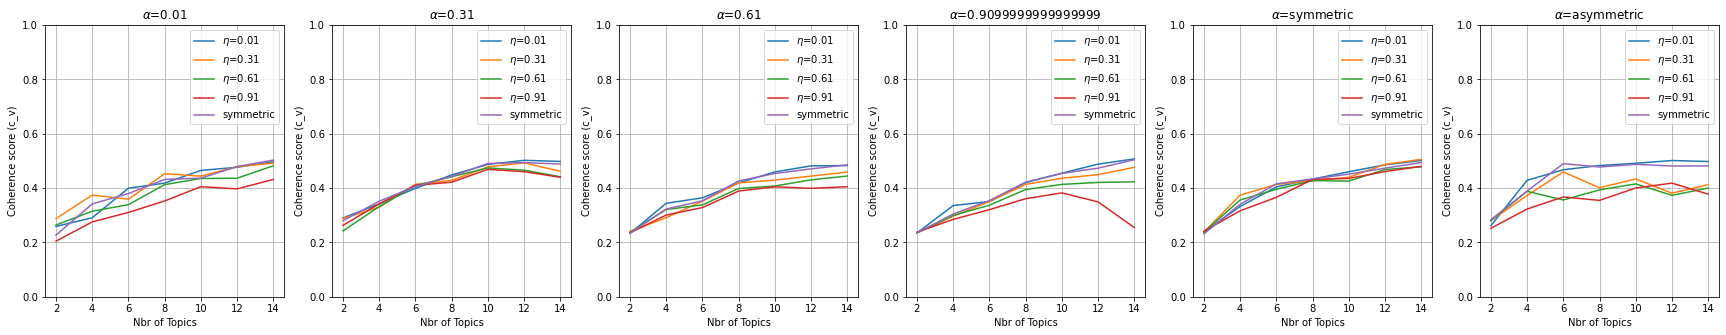

In [46]:
plt.figure('Cohenrence en fonction du nombre de sujet, par valeurs de alpha et eta, pour le corpus réduits aux mots de freq >=50', figsize=(30,5)), plt.clf()
alphas, betas = df_opt_lda_01_sup['Alpha'].unique(), df_opt_lda_01_sup['Beta'].unique()
for a in alphas :
    i = np.argwhere(alphas==a)[0,0]
    axe, df_plot = plt.subplot(1, len(alphas), i+1), df_opt_lda_01_sup[df_opt_lda_01['Alpha']==str(a)]
    axe.set_title(r'$\alpha$='+str(a)), axe.set_xlabel('Nbr of Topics'), axe.set_ylabel('Coherence score (c_v)')
    for b in betas :
        label_b = f'$\eta$={float(b):.2f}' if b != 'symmetric' else b
        df_plot_2 = df_plot[df_plot['Beta']==b]
        axe.plot(df_plot_2['Topics'], df_plot_2['Coherence'], label=label_b)
    axe.legend(loc='best'), axe.set_ylim([0,1]), axe.grid(which='both')
del a, alphas, b, betas, axe, label_b, df_plot, df_plot_2

In [47]:
# Regroupement du Dataframe selon les hyper_paramètres, et description statistique (la moyenne suffit car il n'y a qu'un caclul de cohérence par trio ('Alpha','Beta','Topics'))
scores_sup = df_opt_lda_01_sup.groupby(['Alpha','Beta','Topics']).describe(percentiles=[0.5])[('Coherence','mean')]
# Affichage de la combinaison conduisant au meilleur score
scores_sup[scores_sup == scores_sup.max()]

Alpha               Beta  Topics
0.9099999999999999  0.01  14        0.507367
Name: (Coherence, mean), dtype: float64

### On prend le temps de faire remarquer que cette nouvelle combinaison "optimale" d'hyper-paramètre mène aux valeurs extrèmes des 3 plages d'hyper-paramètres sur lesquelles on a fait l'optimisation !!! 
### <b>!!! Par manque de temps, on ne refera pas une nouvelle optimisation sur de nouvelles plages de paramètres, bien qu'il le faudrait en toute rigueur !!!</b> Notons d'ailleurs que pour le paramètres alpha c'est de toute façon presque impossible, puisqu'il ne peut pas être supérieur à 1.
### Notons enfin que la cohérence moyenne est PLUS FAIBLE que lorsqu'on travaillait sur le corpus de <i>Title</i> sans considération de la fréquence des mots... Ce qui, a priori, devrait être mauvais signe pour nous...
### Par analogie avec la section <b>II.1.d</b>, on re-entraîne un modèle avec les hyper-paramètres "optimaux", et on reproduit le même type de graphe que précédemment :

In [48]:
# liste des hyper-paramètres optimisés
hyper_p_sup = [float(p) if (p!='symmetric')&(p!='asymmetric') else p for p in scores_sup[scores_sup == scores_sup.max()].index.values[0]]
# Construiction d'un modèle de LDA basé sur le BOW tdidf
lda_model_idf_opt_sup = gensim.models.LdaMulticore(corpus=bow_idf_sup, id2word=id2word_sup, num_topics=hyper_p_sup[2], alpha=hyper_p_sup[0], eta=hyper_p_sup[1], random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
# Top words per topics, topics classé selon le score de coherence c_v
top_topics_sup = lda_model_idf_opt_sup.top_topics(corpus=bow_idf_sup, texts=serie_tokensnet_sup.values, dictionary=id2word_sup, coherence='c_v')

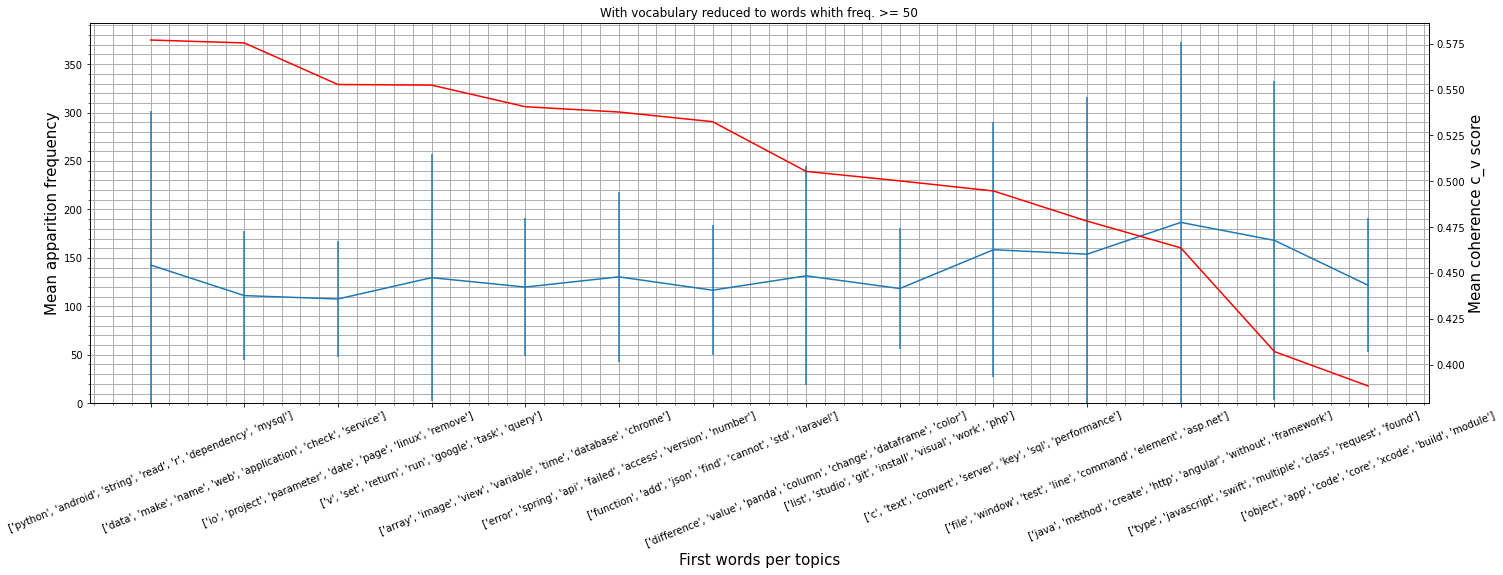

In [49]:
plt.figure('Frequence apparition = errorbar(topics_sup)', figsize=(24,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_title("With vocabulary reduced to words whith freq. >= 50")
axe.set_xlabel('First words per topics', fontsize=15)
axe.set_ylabel('Mean apparition frequency', fontsize=15)
axe.errorbar(x=range(int(hyper_p_sup[2])),
             y=[freq_app[np.array(topic[0])[:,1]].mean() for topic in top_topics_sup], 
             yerr=[freq_app[np.array(topic[0])[:,1]].std() for topic in top_topics_sup])
axe.set_xticks(range(int(hyper_p_sup[2]))), axe.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics_sup], rotation=22)
axe.grid(which='both', linewidth=1), axe.minorticks_on(), axe.set_ylim(ymin=0)
axe2 = axe.twinx()
axe2.set_ylabel('Mean coherence c_v score', fontsize=15)
axe2.plot(range(int(hyper_p_sup[2])),
          [topic[1] for topic in top_topics_sup], color='red')
axe2.set_xticks(range(int(hyper_p_sup[2]))), axe2.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics_sup], rotation=22)
del axe, axe2

### Si la cohérence moyenne sur tous les topics est plus basse, on a en revanche beaucoup - de différence de cohérence d'un sujet à l'autre, ce qui coïncide d'ailleurs également avec beaucoup - de différence de fréquence d'apparition moyenne. Les écart-relatifs en fréquence d'apparition sont eux beaucoup + grands.
### Comme précédemment, affichons les <i>top words</i> par sujet :

In [50]:
df_info_topics_sup = pd.DataFrame(
    data={
    f'Topic n°{i}': [id2word_sup.id2token[n] for n in np.asarray(lda_model_idf_opt_sup.get_topic_terms(i))[:,0]] for i in range(int(hyper_p_sup[2]))
}, 
    index=[f'Top word n°{i}' for i in range(len(lda_model_idf_opt_sup.get_topic_terms(0)))]
)
# Affichage 
df_info_topics_sup

,Topic n°0,Topic n°1,Topic n°2,Topic n°3,Topic n°4,Topic n°5,Topic n°6,Topic n°7,Topic n°8,Topic n°9,Topic n°10,Topic n°11,Topic n°12,Topic n°13
Top word n°0,difference,type,function,object,java,data,v,python,file,error,list,array,c,io
Top word n°1,value,javascript,add,app,method,make,set,android,window,spring,studio,image,text,project
Top word n°2,panda,swift,json,code,create,name,return,string,test,api,git,view,convert,parameter
Top word n°3,column,multiple,find,core,http,web,run,read,line,failed,install,variable,server,date
Top word n°4,change,class,cannot,xcode,angular,application,google,r,command,access,visual,time,key,page
Top word n°5,dataframe,request,std,build,without,check,task,dependency,element,version,work,database,sql,linux
Top word n°6,color,found,laravel,module,framework,service,query,mysql,asp.net,number,php,chrome,performance,remove
Top word n°7,bootstrap,header,table,memory,load,static,c++,like,mvc,property,update,numpy,component,input
Top word n°8,row,button,running,django,mean,jpa,url,format,html,working,package,loop,operator,c#
Top word n°9,getting,library,path,support,directory,docker,bash,folder,j,jquery,rail,call,token,thread


### Il est toujours délicat de donner explicitement un titre/un sujet à chaque topic, mais on trouve qu'il y a un peu de plus de mots liés logiquement entre eux (au sens de l'interprétation de l'esprit humain) au sein d'un même sujet que précédemment. Par exemple :
- topic 0 : panda + column + dataframe + row d'un côté, difference + value + change de l'autre
- topic 5 : data + make + web + application + docker
- topic 7 : string + read + r + folder + format
- topic 9 : error + failed + working
- topic 11 : image + view + form d'un côté, array + database + numpy de l'autre.

### Si on considère le nombre de document par topic (au sens de : pour combien de documents un topic donné est il le plus probable) : 

In [51]:
doc_topic_distrib_sup = np.asarray(lda_model_idf_opt_sup.get_document_topics(bow_idf_sup))
# Nombre de documents associé à chaque topics le plus probable :
topics_per_doc_sup = pd.DataFrame(data={'1st most likely topic':np.argmax(doc_topic_distrib_sup[:,:,1], axis=1)}, 
                                  index=serie_tokensnet_sup.index)
# Affichage
topics_per_doc_sup.value_counts()

1st most likely topic
10                       1145
0                        1071
6                        1035
8                         977
3                         928
9                         899
7                         896
2                         891
11                        863
13                        855
12                        819
1                         805
5                         801
4                         762
dtype: int64

### On a une bien mielleure répartition du nombre de documents par topic, sans doute conséquence d'une dispersion de cohérence beaucoup moins étalée.

### <u><b>A RAJOUTER SOUS 48H : Représentation graphiques de ces thèmes.</b></u>
### Au cours des lignes suivantes, on va chercher à produire une représentation graphiques de ces thèmes. Pour cela, on va effectuer une réduction de de dimension de la matrice TF-IDF grâce à de la TSNE (en imposant un espace réduit de maximaum 3 dimensions), puis on va positionner chaque document dans cet espace, en utilisant comme code couleur le thème inféré le + probable qui lui est associé.

In [161]:
### Re-création de la matrice TF-IDF
# On crée une matrice de zéros
X_idf_sup = np.zeros((len(serie_tokensnet_sup), len(id2word_sup.id2token)))
# Indexage : ligne=document, colonne=clef de id2word
for i in range(len(bow_idf_sup)) :
    for tupl in bow_idf_sup[i] :
        X_idf_sup[i, tupl[0]] = tupl[1]
# On élimine les variables désormais inutiles
del i, tupl
# Affichage
print(X_idf_sup, X_idf_sup.shape)

[[0.76500415 0.64402535 0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.57007845 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (12747, 323)


### Pour la TSNE, on impose 3 composantes (pour que l'affichage graphique soit gérable par un cerveau humain) et une perplexité de 200. En effet, on sait qu'il y a plusieurs centaines de documents associés à chaque thèmes, alors il faut au moins une centaine de "+ proches voisins" pour conduire à une réprésentation graphiques où les documents d'un même thème sont proches dans l'espace réduits.

In [124]:
### Réduction de dimension par TSNE
tsne = TSNE(n_components=3, perplexity=200, random_state=rgn)
X_tsne = tsne.fit_transform(X_idf_sup)
print(X_tsne, X_tsne.shape)

[[ 24.405413   -4.029478  -22.678036 ]
 [ 26.35971     9.140236  -15.179236 ]
 [ -5.1402636  10.519418  -15.52313  ]
 ...
 [ 11.216666   20.593624    3.4864962]
 [ -1.0925676 -10.205933  -26.921703 ]
 [  1.4155171  -9.111139   27.753607 ]] (12747, 3)


### Enfin, l'affichage graphique (en ne représentant "que" un document sur deux pour y voir un peu plus clair) :

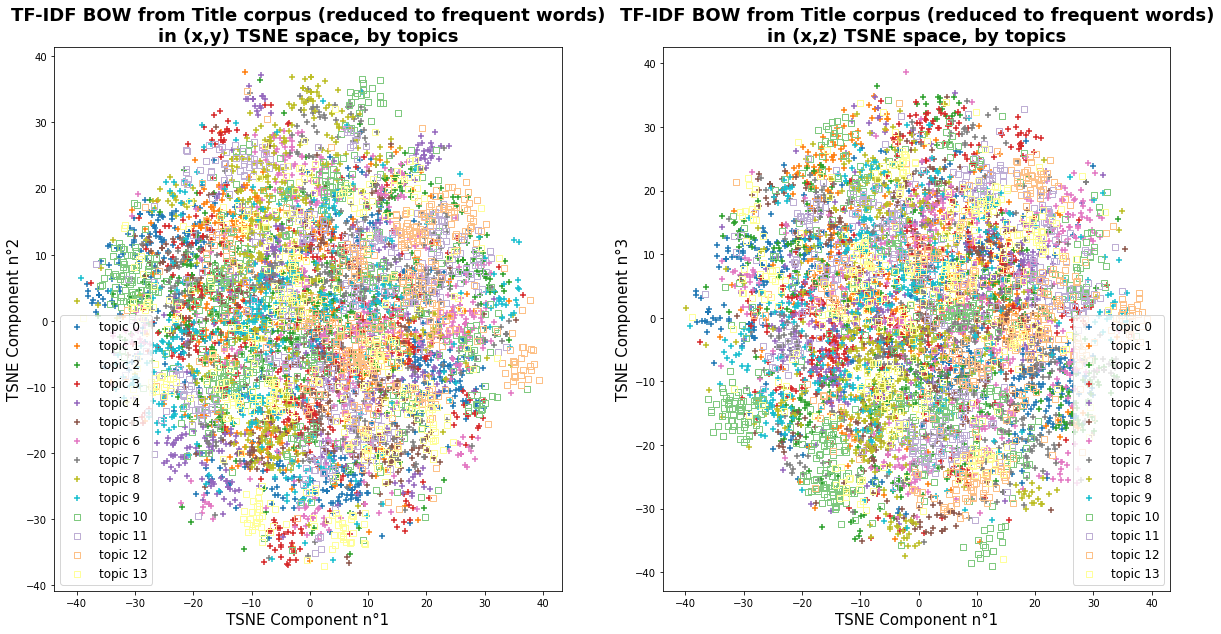

In [180]:
df = pd.DataFrame({'x':X_tsne[:,0], 'y':X_tsne[:,1], 'z':X_tsne[:,2], 't':topics_per_doc_sup.values[:,0]})
plt.figure('Représentation du BOW TF-IDF du corpus de Title réduit, par TSNE', figsize=(20,10)), plt.clf()
axe1, axe2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
axe1.set_title('TF-IDF BOW from Title corpus (reduced to frequent words)\nin (x,y) TSNE space, by topics', fontsize=18, fontweight='bold')
axe2.set_title('TF-IDF BOW from Title corpus (reduced to frequent words)\nin (x,z) TSNE space, by topics', fontsize=18, fontweight='bold')
for t in np.unique(topics_per_doc_sup.values) :
    if t<10 :
        axe1.scatter(df['x'][df['t']==t][::2], df['y'][df['t']==t][::2], label=f'topic {t}', color=cm.tab10.colors[t], marker='+')
        axe2.scatter(df['x'][df['t']==t][::2], df['z'][df['t']==t][::2], label=f'topic {t}', color=cm.tab10.colors[t], marker='+')
    else :
        axe1.scatter(df['x'][df['t']==t][::2], df['y'][df['t']==t][::2], label=f'topic {t}', color=cm.Accent.colors[t-10], marker='s', facecolor='None')
        axe2.scatter(df['x'][df['t']==t][::2], df['z'][df['t']==t][::2], label=f'topic {t}', color=cm.Accent.colors[t-10], marker='s', facecolor='None')        
axe1.legend(loc='best', fontsize=12), axe2.legend(loc='best', fontsize=12)
axe1.set_ylabel('TSNE Component n°2', fontsize=15), axe1.set_xlabel('TSNE Component n°1', fontsize=15)
axe2.set_ylabel('TSNE Component n°3', fontsize=15), axe2.set_xlabel('TSNE Component n°1', fontsize=15)
del df, axe1, axe2

### On voit que régulièrement il y a des petits groupes "compacts", "serrés" de documents d'un même thème, ce qui prouve que nos thèmes ont une certaines cohérence.
### Le seul bémol, c'est qu'on ne voit pas ou peu de portion de l'espace privilégiée par thème (c'est assez évident avec les thèmes représentés par les carrés, où les groupes compacts sont répartis à peu près dans toutes les régions de l'espaces). Dit autrement, chaque thème a une "frontière commune" avec + ou - tous les autres thèmes. Cela peut venir du fait que, avec un vocabulaire réduit à ~300 mots les + fréquents, on a augmenté les chances que les thèmes ne soient pas exclusifs, qu'ils puissent y avoir des liens logiques entre eux.

###### 
### <u><b> Conclusion sur la réduction du vocabulaire aux mots les + fréquents :</b></u>
### Au final, cette réduction du corpus aux mots les + fréquents a amélioré l'inférence de topic, à notre sens, malgré la baisse de score de cohérence sur certains sujets.
### Essayons de reproduire ces processus sur le corpus alternatif nettoyé (voir notebook précédent).

###### 
## <u><b>II.2) LDA sur le corpus alternatif (issu de Title et/ou Body)</b></u>
### (On fera remarquer au lecteur qu'on reproduit toutes les étapes intermédiaires précédentes, donc s'il le désire, il peut se reporter tout de suite aux résultats, à partir du moment où l'optimisation des hyper-paramètres est terminée)

###### 
### <u><b>II.2.a) Chargement de la série correspondante et création d'un BOW pondéré par TF-IDF adapté à ce nouveau corpus.</b></u>

In [133]:
serie_tokensnet_alt = pd.read_csv(abs_path_cache_input + 'serie_tokensnet_sol_alter.csv', index_col=0)
# On reproduit correctement les listes de tokens
serie_tokensnet_alt = pd.Series(data=[re.split(string=x[2:-2], pattern='\', \'') for x in serie_tokensnet_alt.values.reshape(-1)],
                                index=serie_tokensnet_alt.index, 
                                name=serie_tokensnet_alt.columns[0])
# Affichage
serie_tokensnet_alt

2                                 [linq, query, datatable]
3                                    [overload, std, swap]
4                                  [directory, listing, c]
5        [wcf, service, return, datatable, know, often,...
6         [datetime, best, measure, function, performance]
                               ...                        
27120    [common, panda, way, select, filter, row, data...
27121    [suspend, function, callgetapi, called, corout...
27123    [writing, application, react, unable, avoid, s...
27124      [wpf, application, run, linux, mac, .net, core]
27126    [execute, following, statement, python, testin...
Name: Tokens sw lem, Length: 13558, dtype: object

In [134]:
# On recrée une série qui tient le compte de toutes les fréquence d'apparitions de tous les mots de ce corpus
freq_app_alt = flatten_serie(serie_tokensnet_alt).value_counts()

In [135]:
### Création d'un BOW
# initialisation d'un dictionnaire gensim adapté au corpus
id2word_alt = gensim.corpora.Dictionary(serie_tokensnet_alt.values)
# création effective du BOW
bow_alt = [id2word_alt.doc2bow(list_tokens) for list_tokens in serie_tokensnet_alt.values]
### Création BOW passé par tdidf
# initialisation
model_tdidf_alt = gensim.models.TfidfModel(bow_alt, id2word_alt)
# création du BOW pondéré par l'idf
bow_idf_alt = model_tdidf[bow_alt]

###### 
### <u><b>II.2.b) Optimisation des hyper-paramètres.</b></u>

In [136]:
if court_circuiter == False :#1==1:#
    #def optimiser_hyperparam_lda(corpus, texts, dictionary, topics_range=, alphas)
    corpus = bow_idf_alt#gensim.utils.ClippedCorpus(bow_idf, int(len(bow_idf)*0.1))
    texts = serie_tokensnet_alt.values
    dictionary = id2word_alt 
    # Topics range
    topics_range = range(2, 15, 2)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')
    model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
    # iterate through number of topics
    pbar = tqdm.tqdm(total=len(topics_range))
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha=a, eta=b, random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
                cv = gensim.models.CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
        pbar.update(1)
    df_opt_lda_02 = pd.DataFrame(model_results)
    del k, a, b, cv, lda, topics_range, alpha, beta, corpus, dictionary, texts, pbar, model_results
    # Sauvegarde en local dans le cache
    if sauvegarde_fichiers :
        df_opt_lda_02.to_csv(abs_path_cache_output + 'nonsupervise_02_optimisation_hyper_param_lda_tdfidf_solalt.csv')
else :
    df_opt_lda_02 = pd.read_csv(abs_path_cache_output + 'nonsupervise_02_optimisation_hyper_param_lda_tdfidf_solalt.csv', index_col=0)

In [137]:
#df_opt_lda_02.to_csv(abs_path_cache_output + 'nonsupervise_02_optimisation_hyper_param_lda_tdfidf_solalt.csv')
# Affichage
df_opt_lda_02

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.317455
1,2,0.01,0.31,0.471742
2,2,0.01,0.61,0.439108
3,2,0.01,0.9099999999999999,0.456929
4,2,0.01,symmetric,0.447496
...,...,...,...,...
205,14,asymmetric,0.01,0.466171
206,14,asymmetric,0.31,0.525170
207,14,asymmetric,0.61,0.555018
208,14,asymmetric,0.9099999999999999,0.611581


In [138]:
# Regroupement du Dataframe selon les hyper_paramètres, et description statistique (la moyenne suffit car il n'y a qu'un caclul de cohérence par trio ('Alpha','Beta','Topics'))
scores_alt = df_opt_lda_02.groupby(['Alpha','Beta','Topics']).describe(percentiles=[0.5])[('Coherence','mean')]
# Affichage de la combinaison conduisant au meilleur score
scores_alt[scores_alt == scores_alt.max()]

Alpha  Beta  Topics
0.61   0.61  12        0.729661
Name: (Coherence, mean), dtype: float64

### Les hyper-paramètres otpiaux ne conduisent pas aux extrémités de leurs plages d'études. Par rapport au corpus entier issu de <i>Title</i>, on remarquera cette fois que le paramètre alpha a une valeur constante pour l'ensemble des sujets (alors qu'il était 'asymetric' avant), que le nombre de sujet optimal est 50% + élevé, et que la cohérence moyenne est + haute !

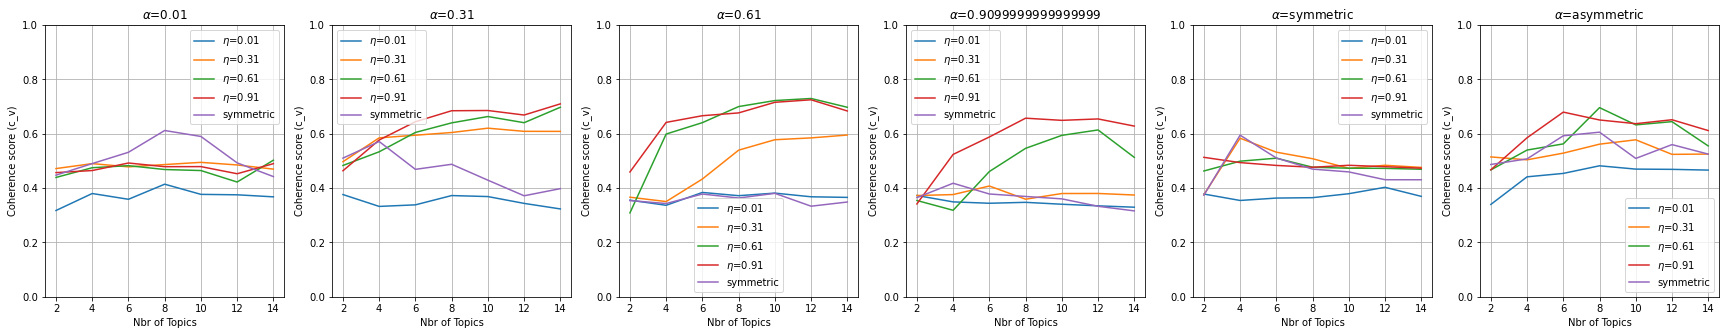

In [139]:
plt.figure('Cohenrence en fonction du nombre de sujet, par valeurs de alpha et eta, pour la solution alternative', figsize=(30,5)), plt.clf()
alphas, betas = df_opt_lda_02['Alpha'].unique(), df_opt_lda_02['Beta'].unique()
for a in alphas :
    i = np.argwhere(alphas==a)[0,0]
    axe, df_plot = plt.subplot(1, len(alphas), i+1), df_opt_lda_02[df_opt_lda_02['Alpha']==a]
    axe.set_title(r'$\alpha$='+str(a)), axe.set_xlabel('Nbr of Topics'), axe.set_ylabel('Coherence score (c_v)')
    for b in betas :
        label_b = f'$\eta$={float(b):.2f}' if b != 'symmetric' else b
        df_plot_2 = df_plot[df_plot['Beta']==b]
        axe.plot(df_plot_2['Topics'], df_plot_2['Coherence'], label=label_b)
    axe.legend(loc='best'), axe.set_ylim([0,1]), axe.grid(which='both')
del a, alphas, b, betas, axe, label_b, df_plot, df_plot_2

###### 
### <u><b>II.2.c) Analyse du modèles avec hyper-paramètres optimaux.</b></u>

In [140]:
# liste des hyper-paramètres optimisés
hyper_p_alt = [float(p) if (p!='symmetric')&(p!='asymmetric') else p for p in scores_alt[scores_alt == scores_alt.max()].index.values[0]]
# Construiction d'un modèle de LDA basé sur le BOW tdidf
lda_model_idf_opt_alt = gensim.models.LdaMulticore(corpus=bow_idf_alt, id2word=id2word_alt, num_topics=hyper_p_alt[2], alpha=hyper_p_alt[0], eta=hyper_p_alt[1], random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
# Top words per topics, topics classé selon le score de coherence c_v
top_topics_alt = lda_model_idf_opt_alt.top_topics(corpus=bow_idf_alt, texts=serie_tokensnet_alt.values, dictionary=id2word_alt, coherence='c_v')

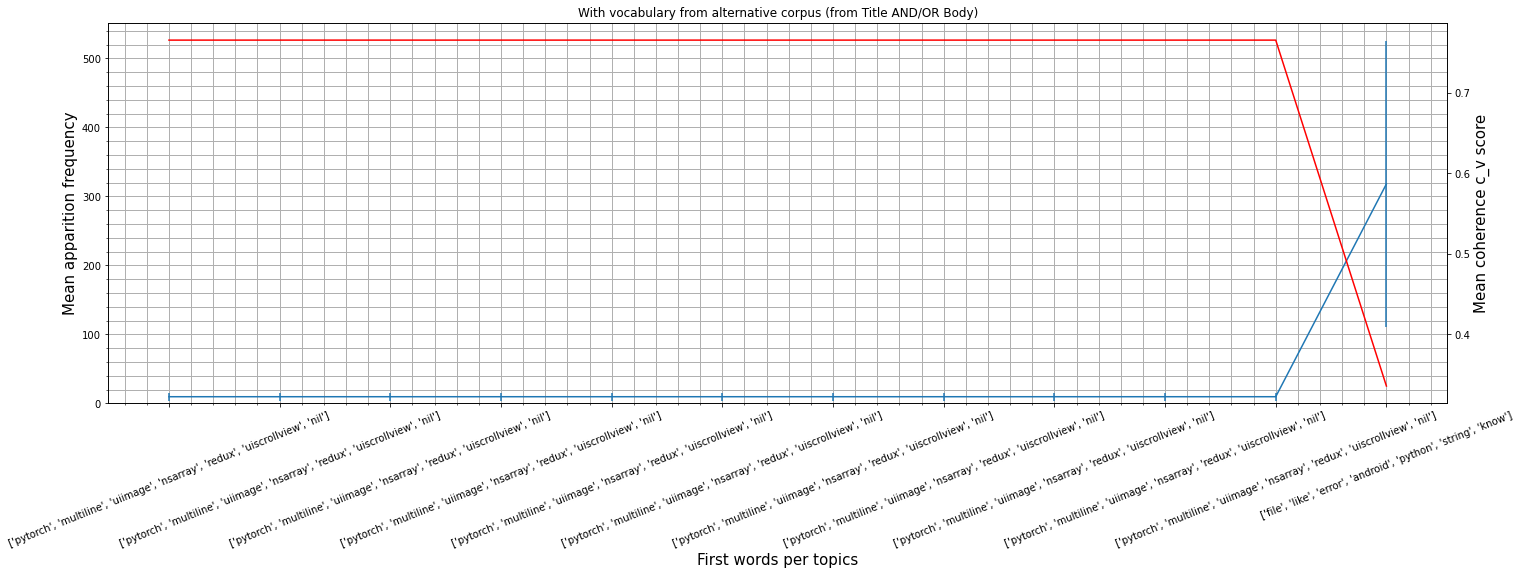

In [141]:
plt.figure('Frequence apparition = errorbar(topics de sol_alt)', figsize=(24,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_title("With vocabulary from alternative corpus (from Title AND/OR Body)")
axe.set_xlabel('First words per topics', fontsize=15)
axe.set_ylabel('Mean apparition frequency', fontsize=15)
axe.errorbar(x=range(int(hyper_p_alt[2])),
             y=[freq_app[np.array(topic[0])[:,1]].mean() for topic in top_topics_alt], 
             yerr=[freq_app[np.array(topic[0])[:,1]].std() for topic in top_topics_alt])
axe.set_xticks(range(int(hyper_p_alt[2]))), axe.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics_alt], rotation=22)
axe.grid(which='both', linewidth=1), axe.minorticks_on(), axe.set_ylim(ymin=0)
axe2 = axe.twinx()
axe2.set_ylabel('Mean coherence c_v score', fontsize=15)
axe2.plot(range(int(hyper_p_alt[2])),
          [topic[1] for topic in top_topics_alt], color='red')
axe2.set_xticks(range(int(hyper_p_alt[2]))), axe2.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics_alt], rotation=22)
del axe, axe2

### Quel constat accablant : 11 sujets sur 12 sont identiques (ou presque), et leur grande cohérence est compensé par la rareté extrême de leurs <i>top words</i>... alors que le 12ème est constitué uniquement des mots les plus fréquents, détruisant sa cohérence...

In [142]:
df_info_topics_alt = pd.DataFrame(
    data={
    f'Topic n°{i}': [id2word_alt.id2token[n] for n in np.asarray(lda_model_idf_opt_alt.get_topic_terms(i))[:,0]] for i in range(int(hyper_p_alt[2]))
}, 
    index=[f'Top word n°{i}' for i in range(len(lda_model_idf_opt_alt.get_topic_terms(0)))]
)
# Affichage 
df_info_topics_alt

,Topic n°0,Topic n°1,Topic n°2,Topic n°3,Topic n°4,Topic n°5,Topic n°6,Topic n°7,Topic n°8,Topic n°9,Topic n°10,Topic n°11
Top word n°0,pytorch,pytorch,pytorch,pytorch,pytorch,pytorch,file,pytorch,pytorch,pytorch,pytorch,pytorch
Top word n°1,multiline,multiline,multiline,multiline,multiline,multiline,like,multiline,multiline,multiline,multiline,multiline
Top word n°2,uiimage,uiimage,uiimage,uiimage,uiimage,uiimage,error,uiimage,uiimage,uiimage,uiimage,uiimage
Top word n°3,nsarray,nsarray,nsarray,nsarray,nsarray,nsarray,android,nsarray,nsarray,nsarray,nsarray,nsarray
Top word n°4,redux,redux,redux,redux,redux,redux,python,redux,redux,redux,redux,redux
Top word n°5,uiscrollview,uiscrollview,uiscrollview,uiscrollview,uiscrollview,uiscrollview,string,uiscrollview,uiscrollview,uiscrollview,uiscrollview,uiscrollview
Top word n°6,nil,nil,nil,nil,nil,nil,know,nil,nil,nil,nil,nil
Top word n°7,coordinatorlayout,coordinatorlayout,coordinatorlayout,coordinatorlayout,coordinatorlayout,coordinatorlayout,work,coordinatorlayout,coordinatorlayout,coordinatorlayout,coordinatorlayout,coordinatorlayout
Top word n°8,activerecord,activerecord,activerecord,activerecord,activerecord,activerecord,data,activerecord,activerecord,activerecord,activerecord,activerecord
Top word n°9,oncreate,oncreate,oncreate,oncreate,oncreate,oncreate,v,oncreate,oncreate,oncreate,oncreate,oncreate


### Il nous est impossible de nommer explicitement ces topics en regard de leurs <i>top words</i>, peut être qu'on manque trop de culture informatique pour voir le lien logique tracé par l'algorithme...
### Et quand on regarde le nombre de documents affilié à chaque topic :

In [143]:
doc_topic_distrib_alt = np.asarray(lda_model_idf_opt_alt.get_document_topics(bow_idf_alt))
# Nombre de documents associé à chaque topics le plus probable :
topics_per_doc_alt = pd.DataFrame(data={'1st most likely topic':np.argmax(doc_topic_distrib_alt[:,:,1], axis=1)}, 
                                  index=serie_tokensnet_alt.index)
# Affichage
topics_per_doc_alt.value_counts()

1st most likely topic
6                        12160
0                         1119
8                           44
3                           38
11                          36
2                           26
9                           26
5                           25
10                          24
4                           23
7                           21
1                           16
dtype: int64

### Le déséquilibre est extrème, de nouveau, avec la quasi totalité des documents attribué au topic de faible cohérence...

### C'est un échec cuisant, et de nouveau, on va tenter d'y remédier en ne conservant dans le corpus QUE les mots de fréquence >= 50.

######
### <u><b>II.2.d) Avec corpus réduit aux mots présents >= 50 fois.</b></u>
### De nouveau, on reproduit toutes les étapes précédentes, on invite donc le lecteur à se rendre directement à l'issue de l'optimisation des hyper-paramètres.

In [144]:
freq_app_alt[freq_app_alt>=50].sum(), flatten_serie(serie_tokensnet_alt).shape[0]

(289087, 384078)

### Notons juste que les mots de fréquence >= 50 représentent presque 75% du nombre total de mots du corpus, cette opération est donc encore plus justifié dans le cas du corpus alternatif que dans le cas du corpus issu de Title.

In [145]:
# on élimine les mots de fréquence < 50
serie_tokensnet_alt_sup = serie_tokensnet_alt.apply(lambda x : [w for w in x if freq_app_alt[w]>=50])
# on élimine les documents vides
serie_tokensnet_alt_sup = serie_tokensnet_alt_sup[serie_tokensnet_alt_sup.apply(lambda x : len(x)>0)]
# Affichage :
serie_tokensnet_alt_sup

2                                            [linq, query]
3                                                    [std]
4                                           [directory, c]
5        [service, return, know, often, topic, far, whe...
6                  [datetime, best, function, performance]
                               ...                        
27120    [common, panda, way, select, filter, row, data...
27121                [function, called, another, function]
27123    [writing, application, react, unable, avoid, s...
27124      [wpf, application, run, linux, mac, .net, core]
27126    [execute, following, statement, python, testin...
Name: Tokens sw lem, Length: 12118, dtype: object

In [146]:
### Création d'un BOW
# initialisation d'un dictionnaire gensim adapté au corpus
id2word_alt_sup = gensim.corpora.Dictionary(serie_tokensnet_alt_sup.values)
# création effective du BOW
bow_alt_sup = [id2word_alt_sup.doc2bow(list_tokens) for list_tokens in serie_tokensnet_alt_sup.values]
### Création BOW passé par tdidf
# initialisation
model_tdidf_alt_sup = gensim.models.TfidfModel(bow_alt_sup, id2word_alt_sup)
# création du BOW pondéré par l'idf
bow_idf_alt_sup = model_tdidf_sup[bow_alt_sup]

In [148]:
if 1==1:#court_circuiter == False :#
    #def optimiser_hyperparam_lda(corpus, texts, dictionary, topics_range=, alphas)
    corpus = bow_idf_alt_sup#gensim.utils.ClippedCorpus(bow_idf, int(len(bow_idf)*0.1))
    texts = serie_tokensnet_alt_sup.values
    dictionary = id2word_alt_sup 
    # Topics range
    topics_range = range(2, 15, 2)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')
    model_results = {'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}
    # iterate through number of topics
    pbar = tqdm.tqdm(total=len(topics_range))
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, alpha=a, eta=b, random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=5)
                cv = gensim.models.CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
        pbar.update(1)
    df_opt_lda_02_sup = pd.DataFrame(model_results)
    del k, a, b, cv, lda, topics_range, alpha, beta, corpus, dictionary, texts, pbar, model_results
    # Sauvegarde en local dans le cache
    if sauvegarde_fichiers :
        df_opt_lda_02_sup.to_csv(abs_path_cache_output + 'nonsupervise_02_optimisation_hyper_param_lda_tdfidf_solalt_sup.csv')
else :
    df_opt_lda_02_sup = pd.read_csv(abs_path_cache_output + 'nonsupervise_02_optimisation_hyper_param_lda_tdfidf_solalt_sup.csv', index_col=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [38:12<00:00, 339.93s/it]

In [150]:
df_opt_lda_02_sup

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.402407
1,2,0.01,0.31,0.413531
2,2,0.01,0.61,0.394106
3,2,0.01,0.91,0.392482
4,2,0.01,symmetric,0.379402
...,...,...,...,...
205,14,asymmetric,0.01,0.398372
206,14,asymmetric,0.31,0.363967
207,14,asymmetric,0.61,0.368163
208,14,asymmetric,0.91,0.363211


In [151]:
# Regroupement du Dataframe selon les hyper_paramètres, et description statistique (la moyenne suffit car il n'y a qu'un caclul de cohérence par trio ('Alpha','Beta','Topics'))
scores_alt_sup = df_opt_lda_02_sup.groupby(['Alpha','Beta','Topics']).describe(percentiles=[0.5])[('Coherence','mean')]
# Affichage de la combinaison conduisant au meilleur score
scores_alt_sup[scores_alt_sup == scores_alt_sup.max()]

Alpha  Beta  Topics
0.91   0.91  10        0.464605
Name: (Coherence, mean), dtype: float64

### La cohérence moyenne a encore baissé, c'est même la plus basse qu'on ait jamais eu jusqu'à présent. Notons que le nombre de document est un peu - fort qu'avec tous les mots (indépendemment de leur fréquence), mais surtout nettement moins fort que par rapport au corpus réduit au mots fréquents issu de Title !

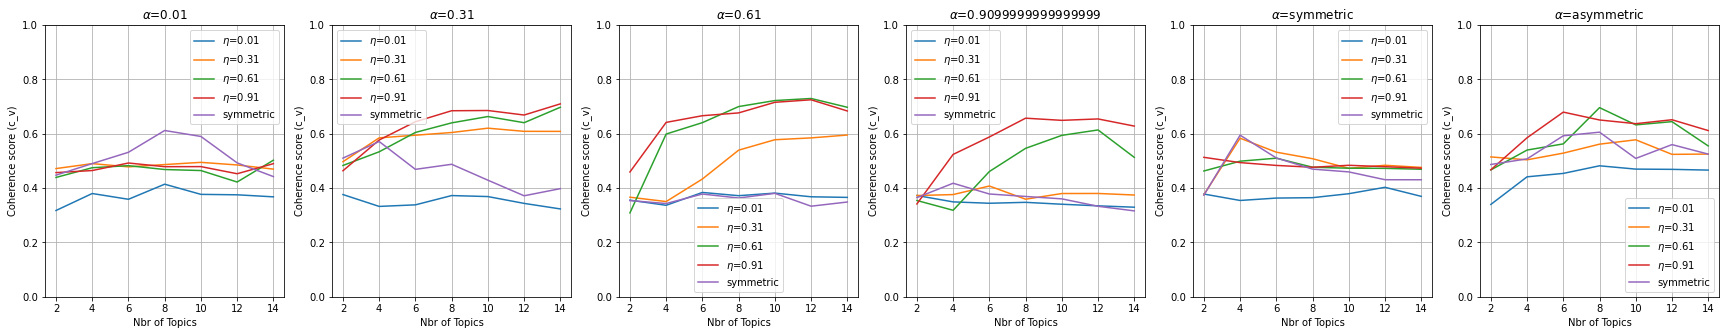

In [169]:
plt.figure('Cohenrence en fonction du nombre de sujet, par valeurs de alpha et eta, pour la solution alternative avec corpus réduits aux >=50', figsize=(30,5)), plt.clf()
alphas, betas = df_opt_lda_02_sup['Alpha'].unique(), df_opt_lda_02_sup['Beta'].unique()
for a in alphas :
    i = np.argwhere(alphas==a)[0,0]
    axe, df_plot = plt.subplot(1, len(alphas), i+1), df_opt_lda_02[df_opt_lda_02['Alpha']==str(a)]
    axe.set_title(r'$\alpha$='+str(a)), axe.set_xlabel('Nbr of Topics'), axe.set_ylabel('Coherence score (c_v)')
    for b in betas :
        label_b = f'$\eta$={float(b):.2f}' if b != 'symmetric' else b
        df_plot_2 = df_plot[df_plot['Beta']==str(b)]
        axe.plot(df_plot_2['Topics'], df_plot_2['Coherence'], label=label_b)
    axe.legend(loc='best'), axe.set_ylim([0,1]), axe.grid(which='both')
del a, alphas, b, betas, axe, label_b, df_plot, df_plot_2

In [153]:
# liste des hyper-paramètres optimisés
hyper_p_alt_sup = [float(p) if (p!='symmetric')&(p!='asymmetric') else p for p in scores_alt_sup[scores_alt_sup == scores_alt_sup.max()].index.values[0]]
# Construiction d'un modèle de LDA basé sur le BOW tdidf
lda_model_idf_opt_alt_sup = gensim.models.LdaMulticore(corpus=bow_idf_alt_sup, id2word=id2word_alt_sup, num_topics=hyper_p_alt_sup[2], alpha=hyper_p_alt_sup[0], eta=hyper_p_alt_sup[1], random_state=rgn, chunksize=100, passes=10, per_word_topics=True, workers=3)
# Top words per topics, topics classé selon le score de coherence c_v
top_topics_alt_sup = lda_model_idf_opt_alt_sup.top_topics(corpus=bow_idf_alt_sup, texts=serie_tokensnet_alt_sup.values, dictionary=id2word_alt_sup, coherence='c_v')

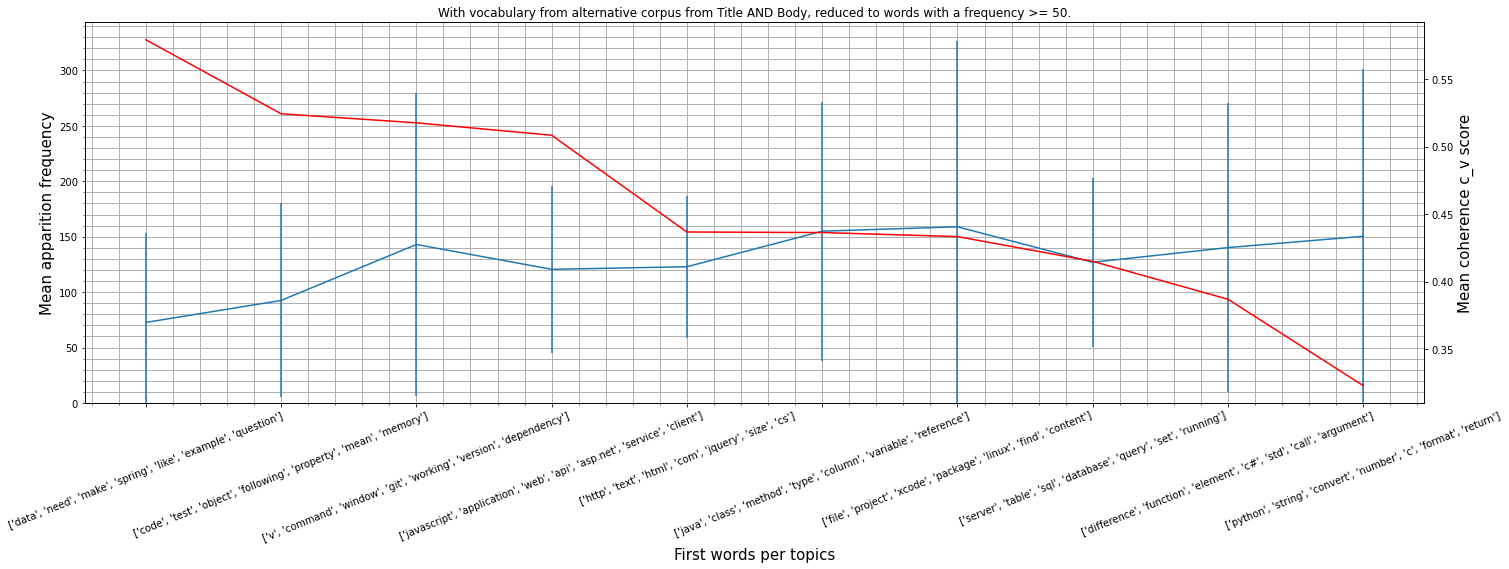

In [154]:
plt.figure('Frequence apparition = errorbar(topics de sol_alt_sup)', figsize=(24,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_title("With vocabulary from alternative corpus from Title AND Body, reduced to words with a frequency >= 50.")
axe.set_xlabel('First words per topics', fontsize=15)
axe.set_ylabel('Mean apparition frequency', fontsize=15)
axe.errorbar(x=range(int(hyper_p_alt_sup[2])),
             y=[freq_app[np.array(topic[0])[:,1]].mean() for topic in top_topics_alt_sup], 
             yerr=[freq_app[np.array(topic[0])[:,1]].std() for topic in top_topics_alt_sup])
axe.set_xticks(range(int(hyper_p_alt_sup[2]))), axe.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics_alt_sup], rotation=22)
axe.grid(which='both', linewidth=1), axe.minorticks_on(), axe.set_ylim(ymin=0)
axe2 = axe.twinx()
axe2.set_ylabel('Mean coherence c_v score', fontsize=15)
axe2.plot(range(int(hyper_p_alt_sup[2])),
          [topic[1] for topic in top_topics_alt_sup], color='red')
axe2.set_xticks(range(int(hyper_p_alt_sup[2]))), axe2.set_xticklabels([list(np.array(topic[0])[:7,1]) for topic in top_topics_alt_sup], rotation=22)
del axe, axe2

### Comme lors de la précédente réduction de corpus aux mots les + fréquents, la baisse de cohérence global s'accompagne d'une dispersion de cohérence moins importante entre topics.
### On pousse un soupir de soulagement : les 10 topics sont constitués de <i>top words</i> très différents d'un topics à l'autre.

In [155]:
df_info_topics_alt_sup = pd.DataFrame(
    data={
    f'Topic n°{i}': [id2word_alt_sup.id2token[n] for n in np.asarray(lda_model_idf_opt_alt_sup.get_topic_terms(i))[:,0]] for i in range(int(hyper_p_alt_sup[2]))
}, 
    index=[f'Top word n°{i}' for i in range(len(lda_model_idf_opt_alt_sup.get_topic_terms(0)))]
)
# Affichage 
df_info_topics_alt_sup

,Topic n°0,Topic n°1,Topic n°2,Topic n°3,Topic n°4,Topic n°5,Topic n°6,Topic n°7,Topic n°8,Topic n°9
Top word n°0,python,server,difference,javascript,v,java,code,file,http,data
Top word n°1,string,table,function,application,command,class,test,project,text,need
Top word n°2,convert,sql,element,web,window,method,object,xcode,html,make
Top word n°3,number,database,c#,api,git,type,following,package,com,spring
Top word n°4,c,query,std,asp.net,working,column,property,linux,jquery,like
Top word n°5,format,set,call,service,version,variable,mean,find,size,example
Top word n°6,return,running,argument,client,dependency,reference,memory,content,cs,question
Top word n°7,character,work,case,create,installed,static,see,directory,input,point
Top word n°8,space,connection,example,.net,local,interface,process,created,browser,know
Top word n°9,replace,like,like,google,default,name,give,create,user,look


### De nouveau, on retrouve régulièrement des liens logiques interprétable par un être humain entre plusieurs mots d'un même topic. Par exemple :
- topic 0 : string + c + character + space d'un côté, convert + replace de l'autre
- topic 1 : server + table + sql + database + query + connection 
- topic 2 : function + element + argument + call d'un côté, case + example + like de l'autre
- topic 3 : l'intégralité des mots
- etc

### Si on affiche le nombre de documents par topic :

In [156]:
doc_topic_distrib_alt_sup = np.asarray(lda_model_idf_opt_alt_sup.get_document_topics(bow_idf_alt_sup))
# Nombre de documents associé à chaque topics le plus probable :
topics_per_doc_alt_sup = pd.DataFrame(data={'1st most likely topic':np.argmax(doc_topic_distrib_alt_sup[:,:,1], axis=1)}, 
                                      index=serie_tokensnet_alt_sup.index)
# Affichage
topics_per_doc_alt_sup.value_counts()

1st most likely topic
0                        2278
9                        1387
8                        1281
7                        1174
5                        1113
4                        1055
6                        1018
3                         962
1                         928
2                         922
dtype: int64

### La répartirtion de nouveau bien meilleure (malgré la tête nettement occupée par le topic le - cohérent), avec - c'est à noter - le topic le + cohérent qui est le deuxième + remplit ! 

### <u><b>A RAJOUTER SOUS 48H : Représentation graphiques de ces thèmes.</b></u>
### Comme p^récédemment avec le corpus réduit issu de <i>Title</i>, on reprocède à une représentation graphique des documents par thèmes dans un espace réduit calculé par une TSNE.

In [160]:
# On crée une matrice de zéros
X_idf_alt_sup = np.zeros((len(serie_tokensnet_alt_sup), len(id2word_alt_sup.id2token)))
# Indexage : ligne=document, colonne=clef de id2word
for i in range(len(bow_idf_alt_sup)) :
    for tupl in bow_idf_alt_sup[i] :
        X_idf_alt_sup[i, tupl[0]] = tupl[1]
# On élimine les variables désormais inutiles
del i, tupl
# Affichage
print(X_idf_alt_sup, X_idf_alt_sup.shape)

[[0.76500415 0.64402535 0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (12118, 1347)


In [181]:
tsne_alt_sup = TSNE(n_components=3, perplexity=300, random_state=rgn)
X_tsne_alt_sup = tsne_alt_sup.fit_transform(X_idf_alt_sup)
print(X_tsne_alt_sup, X_tsne_alt_sup.shape)

[[-21.06218    30.604721  -12.566445 ]
 [-30.079105   15.510147  -21.157318 ]
 [ 57.484867    8.76523    18.061518 ]
 ...
 [  5.2395167  37.61433     9.273421 ]
 [-37.59977     3.0067732  48.08116  ]
 [-34.330402  -14.196696  -17.329    ]] (12118, 3)


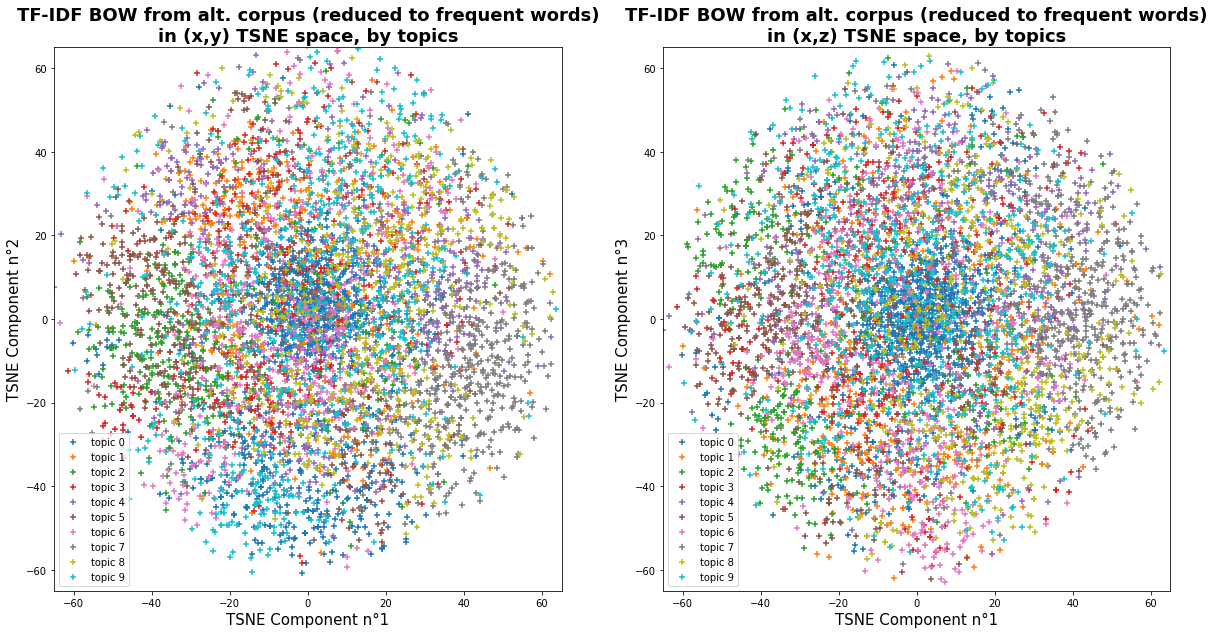

In [183]:
df = pd.DataFrame({'x':X_tsne_alt_sup[:,0], 'y':X_tsne_alt_sup[:,1], 'z':X_tsne_alt_sup[:,2], 't':topics_per_doc_alt_sup.values[:,0]})
plt.figure('Représentation du BOW TF-IDF du corpus aletrantif réduit, par TSNE', figsize=(20,10)), plt.clf()
axe1, axe2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
axe1.set_title('TF-IDF BOW from alt. corpus (reduced to frequent words)\nin (x,y) TSNE space, by topics', fontsize=18, fontweight='bold')
axe2.set_title('TF-IDF BOW from alt. corpus (reduced to frequent words)\nin (x,z) TSNE space, by topics', fontsize=18, fontweight='bold')
for t in np.unique(topics_per_doc_alt_sup.values) :
    axe1.scatter(df['x'][df['t']==t][::2], df['y'][df['t']==t][::2], label=f'topic {t}', color=cm.tab10.colors[t], marker='+')
    axe2.scatter(df['x'][df['t']==t][::2], df['z'][df['t']==t][::2], label=f'topic {t}', color=cm.tab10.colors[t], marker='+')
axe1.legend(loc='best'), axe2.legend(loc='best')
axe1.set_xlim([-65,65]), axe1.set_ylim([-65,65]), axe2.set_xlim([-65,65]), axe2.set_ylim([-65,65])
axe1.set_ylabel('TSNE Component n°2', fontsize=15), axe1.set_xlabel('TSNE Component n°1', fontsize=15)
axe2.set_ylabel('TSNE Component n°3', fontsize=15), axe2.set_xlabel('TSNE Component n°1', fontsize=15)
del df, axe1, axe2

### On ne trouve pas de petits groupes "compacts", "serrés" de documents d'un même thème, comme c'était le cas précédemment. C'est peut être lié au fait que le seuil de fréquence >= 50 a beaucoup moins réduit la taille du vocabulaire du corpus alternatif que ça n'avait été le cas pour le corpus de Title.
### On a en revanche l'impression que cette baisse de concentration "locale" ait été parttiellement compensée (pour ceratins thèmes) par une concentration plus "gloable" dans de grandes régions de l'espace. Par exemple : le thème n°2 (vert) semble avoir la garnde majorité de ces documents dans la portion de l'espace où la 1ère composante (les "x") est négative, alors que ce serait le contraire (1ère composante positive) pour le thème 7 (gris).

###### 
## <u><b>II.3) Conclusion de l'approche non supervisée.</b></u>
### Le premier point à retenir est qu'il faut absolument réduire le corpus aux mots de fréquence supérieur à un certain seuil (typiquement 50 fois pour 13000 documents) pour commencer à voir des liens logiques entre les mots les plus probables associés d'un même thème, ET pour avoir une répartition relativement homogène des documents par thème.
### Le second est qu'on a désormais un doute quant à l'utilité du score de cohérence, puisque c'est finalement les deux fois où l'on avait le moins de cohérence moyenne (mais également le moins de dispersion de cohérence d'un sujet à l'autre) qu'on a réussit le mieux à interpréter les logiques constitutives des topics.
### Malgré tout, même dans les cas les plus favorables, on n'arrive pas toujours à trouver un sujet global évident par topic. On a même plusieurs fois trouvé deux ensemble de mots ayant leur propre logique au sein d'un même topic.
### En l'état, cette méthode nous laisser sur notre faim, d'autant que par manque de temps, on ne peut pas tester d'autres algorithmes non supervisés comme les <i>Negative Matrix Factorisation</i>, brièvement évoquées dans le cours associé à ce projet.

### PS : Ci-dessous, on efface des variables inutile pour l'approche supervisée qui arrive en section suivante.
### PS : Si vous voulez les conserver, changer la condition 1==1 en 1==0

In [394]:
if 1 == 1 :
    del serie_tokensnet_sup, serie_tokensnet_alt, serie_tokensnet_alt_sup
    del doc_topic_distrib, doc_topic_distrib_sup, doc_topic_distrib_alt, doc_topic_distrib_alt_sup
    del df_info_topics, df_info_topics_sup, df_info_topics_alt, df_info_topics_alt_sup
    del hyper_p, hyper_p_sup, hyper_p_alt, hyper_p_alt_sup
    del lda_model, lda_model_idf_opt, lda_model_idf_opt_alt, lda_model_idf_opt_sup, lda_model_idf_opt_alt_sup
    del bow_idf_alt_sup, bow_idf_alt, bow_idf_sup

# 

# 
# <b><u>III) Approche supervisée.</u></b>

#  
## <b><u>III.1) Mise en place de la pipeline grâce à l'approche BOW.</u></b>
### On commence par "se faire la main" avec le processus de prédiction des mots-clefs de <i>Tags</i>, en trouvant une manière de les prédire à partir du BOW issu de <i>Title</i> crée en section précédente. Ca constituera notre "baseline".

######  
### <b><u>III.1.a) Création d'une matrice de <i>features</i> adaptée.</u></b>

### Ici, la matrice de features sera celle correspondant au BOW issu du TFIDF appliqué à la série de tokens (par ailleurs matrice creuse).

In [47]:
# On crée une matrice de zéros
X = np.zeros((len(serie_tokensnet), len(flatten_serie(serie_tokensnet).unique())))
# Indexage : ligne=document, colonne=clef de id2word
for i in range(len(bow_idf)) :
    for tupl in bow_idf[i] :
        X[i, tupl[0]] = tupl[1]
# On élimine les variables désormais inutiles
del i, tupl
# Affichage
print(X, X.shape)#, print(X.shape)

[[0.69743003 0.54777743 0.46209441 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.59832595 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.47082032 0.47082032]] (13558, 8305)


######  
### <b><u>III.1.b) Réduction de dimension.</u></b>

### Les dimensions d'une telle matrice sont trop imposantes pour espérer réaliser une prédiction en une durée descente. Grâce à un noyau gaussien, on calcule la projection de cette matrice dans un esapce de dimension réduit (on prend comme dimension réduite 300 vecteurs constituant cette nouvelle base)

In [48]:
from sklearn.kernel_approximation import Nystroem

In [49]:
# On initialise un Nystroem pour envoyer les donner dans un espace de dimensions réduites grâce à un kernel gaussien
feature_map_nystroem = Nystroem(gamma=.2, random_state=rgn, n_components=300)
# On transforme notre matrice X (tfidf) grâce à ce Nystroem
X_ny = feature_map_nystroem.fit_transform(X)
print(X_ny.shape)

(13558, 300)


### Maintenant, séparation du jeu d'entraînement et jeu de test

In [50]:
X_train, X_test = X_ny[lignes_train], X_ny[lignes_test]
Y_train, Y_test = np.array([liste for liste in serie_tags.loc[indx_train].values]), np.array([liste for liste in serie_tags.loc[indx_test].values])

### On vérifie qu'il y a bien 5 tags par document :

In [51]:
serie_tags.apply(lambda x : len(x)).value_counts()

5    13558
Name: Tags tokens, dtype: int64

######  
### <b><u>III.1.c) Prédiction avec MultiOutputClassifier.</u></b>
### On utilise cette fonction de sklearn car il faut faire 5 prédictions (on a 5 tags par document), a priori indépendantes. Pour gagner du temps, l'estimateur utilisé pour mettre au point cette pipeline sera la régression logistique, qu'on sait d'expérience être relativement rapide à livrer des prédictions même sur un si grand nombre de documents.

### !!!! LE SCORE EST UNE METRIQUE DE NOTRE CREATION !!! C'est la fonction intersection_metric, qui calcule le pourcentage de valeurs commune entre une liste de tags et une liste de prédiction, par document !!!!

In [52]:
### ENtraînement
pbar = tqdm.tqdm(total=1)
moc = MultiOutputClassifier(estimator=LogisticRegression(), n_jobs=14)
moc.fit(X_train, Y_train)
pbar.update(1)
del pbar

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:40<00:00, 160.13s/it]

In [53]:
### Prédiction sur les deux jeux
pbar = tqdm.tqdm(total=2)
Y_pred_test = moc.predict(X_test)
pbar.update(1)
Y_pred_train = moc.predict(X_train)
pbar.update(1)
del pbar


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]

### Calcule des scores avec notre métrique personnelle, sur jeu de test et jeu d'entraînement.

In [54]:
intersection_metric(Y_test, Y_pred_test), intersection_metric(Y_train, Y_pred_train)

(0.12104228121927237, 0.12402528977871444)

### Ca fonctionne, on peut donc se lancer dans la création de features avec Word2Vec, BERT, et USE.
### On notera que cette baseline conduit à prédire statistiquement un tag... sur huit !!! Soit moins d'un sur 5...

In [55]:
del X_ny, Y_pred_test, Y_pred_train

######  
## <b><u>III.2) Importations des séries de tokens non nettoyées.</u></b>
### Comme annoncé dans le notebook pérécédent, on doit utiliser pour ces méthodes d'extractions de features (basées sur le word embedding) des phrases complètes, non nettoyées (pas de suppression de SW, pas de lemmatisation).

In [56]:
tokens_title = pd.read_csv(abs_path_cache_input + 'serie_title.csv', index_col=0)
# On reproduit correctement les listes de tokens
tokens_title = pd.Series(data=[re.split(string=x[2:-2], pattern='\' \'') for x in tokens_title.values.reshape(-1)],
                         index=tokens_title.index, 
                         name=tokens_title.columns[0])
# Affichage de contrôle
tokens_title#.loc[serie_tokens.index[np.random.randint(0, len(serie_tokens), len(serie_tokens)//2)]]

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]


2                          [linq, query, on, a, datatable]
3                           [how, to, overload, std, swap]
4        [how, do, you, get, a, directory, listing, in, c]
5                    [returning, datatables, in, wcf, net]
6        [is, datetime, now, the, best, way, to, measur...
                               ...                        
27120    [select, rows, in, pandas, multiindex, dataframe]
27121    [suspend, function, callgetapi, should, be, ca...
27123    [can, t, perform, a, react, state, update, on,...
27124    [can, wpf, applications, be, run, in, linux, o...
27126    [why, does, if, none, eq, a, seem, to, evaluat...
Name: Title tokens, Length: 13558, dtype: object

In [57]:
tokens_solalt = pd.read_csv(abs_path_cache_input + 'serie_tokens_sol_alter.csv', index_col=0)
# On reproduit correctement les listes de tokens
tokens_solalt = pd.Series(data=[re.split(string=x[2:-2], pattern='\' \'') for x in tokens_solalt.values.reshape(-1)],
                         index=tokens_solalt.index, 
                         name=tokens_solalt.columns[0])
# Affichage de contrôle
tokens_solalt#.loc[serie_tokens.index[np.random.randint(0, len(serie_tokens), len(serie_tokens)//2)]]

2                          [linq, query, on, a, datatable]
3                           [how, to, overload, std, swap]
4        [how, do, you, get, a, directory, listing, in, c]
5        [i, have, a, wcf, service, from, which, i, wan...
6        [is, datetime, now, the, best, way, to, measur...
                               ...                        
27120    [what, are, the, most, common, pandas, ways, t...
27121    [suspend, function, callgetapi, should, be, ca...
27123    [i, am, writing, an, application, in, react, a...
27124    [can, wpf, applications, be, run, in, linux, o...
27126    [if, you, execute, the, following, statement, ...
Name: Tokens, Length: 13558, dtype: object

######  
## <b><u>III.3) Utilisation de Word2Vec.</u></b>
### On reprend ici énormément de lignes de codes telles que présentées dans le notebook d'analyse des tweets, donné dans la page de présentation du projet (https://openclassrooms.com/fr/paths/148/projects/111/assignment), afin de ne pas perdre trop de temps avec l'exploration des librairies python corrspondantes.

In [58]:
# On recrée les jeux d'entraînement et de test
Y_train, Y_test = np.array([liste for liste in serie_tags.loc[indx_train].values]), np.array([liste for liste in serie_tags.loc[indx_test].values])

### On prépare des entrées de la fonction d'extarction de features, notamment la forme du corpus de texte.

In [59]:
sentences_w2v_title = tokens_title.values#serie_tokens.values
maxlen_title = tokens_title.apply(lambda x : len(x)).max()
print(maxlen_title)

25


###### 
### <u><b>III.2.a) Optimisations d' hyper-paramètres de plongements de mots : taille de la fenêtre.</b></u>
### Il y aurait de nombreux hyper-paramètres à optimiser. Mais en réalité :
- on préfère ne pas toucher à <i>w2v_size</i>, le nombre de composantes de l'espace de plongement (en le laissant à 300, faible nombre en regard des 8300 mots du vocabulaire de <i>Title</i>) pour des raisons de temps de calculs, qu'on cherche à limiter ;
- on a besoin de laisser <i>w2v_min_count</i> sur 1, car on sait qu'il y a des mots de <i>Title</i> composés d'une seule lettre.
- <i>w2v_epochs</i> est un nombre d'itérations, même s'il peut avoir un impact sur la matrice de plongement finale, notre volonté de s'épargner du temps de calcul devrait nous dissuader de tester plusieurs valeurs pour ce paramètre (on laisse la valeur 100 pour être sûr de faire nénamoins "assez" d'itérations lors des calculs...

### Donc au final, il ne reste que la taille de la fenêtre de contexte <i>w2v_window</i>.
### On utilisera de nouveau la combinaison MultiOutputClassifier + LogisticRegression, ainsi que notre métrique personnelle "intersection_metric", pour évaluer les résulats pour chaque valeur de taille de fenêtre.

In [60]:
# Initialisation du tableau dans lequel on va sauvegarder les données calculées :
tab_sauvegarde = []
pbar = tqdm.tqdm(total=len([5, 10, 50, 100]))
# On parcours la taille de la fenêtre
for w2v_window in [5, 10, 50, 100]:
    ### Création des features de word embedding
    feat_w2v_train, feat_w2v_test = fct_w2v_embedding(
        sentences = sentences_w2v_title, 
        maxlen = maxlen_title, 
        w2v_size = 300, 
        w2v_window = w2v_window, 
        w2v_min_count = 1, 
        w2v_epochs = 100, 
        lignes_train = lignes_train, 
        lignes_test = lignes_test,
        no_print = True
    )
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
    moc.fit(feat_w2v_train, Y_train)
    # Prediction sur jeux train et test
    Y_pred_train, Y_pred_test = moc.predict(feat_w2v_train), moc.predict(feat_w2v_test)
    pbar.update(1)
    # Calculs d'intersection metric sur ces jeux
    score_train, score_test = intersection_metric(Y_train, Y_pred_train), intersection_metric(Y_test, Y_pred_test)
    ### Sauvegarde des données calculées
    tab_sauvegarde.append([w2v_window, feat_w2v_train, feat_w2v_test, moc, Y_pred_train, Y_pred_test, score_train, score_test])
    print(f'Pour w2v_window={w2v_window:.0f}, on a score_train={score_train:.2f}, score_test={score_test:.2f}')
    del Y_pred_train, Y_pred_test, moc, feat_w2v_train, feat_w2v_test, score_train, score_test
del pbar

 25%|████████████████████▊                                                              | 1/4 [04:24<13:12, 264.04s/it]

Pour w2v_window=5, on a score_train=0.39, score_test=0.25


 50%|█████████████████████████████████████████▌                                         | 2/4 [08:57<08:58, 269.35s/it]

Pour w2v_window=10, on a score_train=0.43, score_test=0.25


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [14:55<05:09, 309.86s/it]

Pour w2v_window=50, on a score_train=0.46, score_test=0.25


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [20:51<00:00, 328.32s/it]

Pour w2v_window=100, on a score_train=0.46, score_test=0.25


### On en fait un graphe :

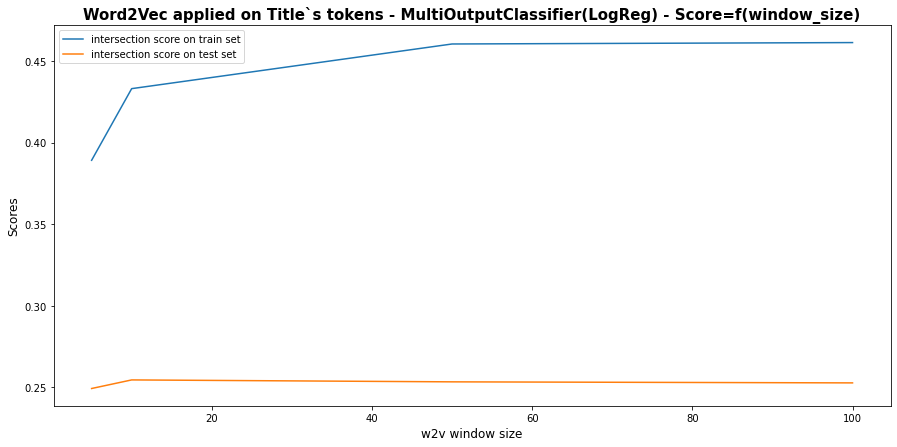

In [61]:
plt.figure('W2V logreg title, score=f(taille fenêtre)', figsize=(15,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_title('Word2Vec applied on Title`s tokens - MultiOutputClassifier(LogReg) - Score=f(window_size)', fontsize=15, fontweight='bold')
axe.set_ylabel('Scores', fontsize=12), axe.set_xlabel('w2v window size', fontsize=12)
w2v_window, score_train, score_test = [], [], []
for i in range(len(tab_sauvegarde)):
    w2v_window.append(tab_sauvegarde[i][0]), score_train.append(tab_sauvegarde[i][-2]), score_test.append(tab_sauvegarde[i][-1])
axe.plot(w2v_window, score_train, label='intersection score on train set'), axe.plot(w2v_window, score_test, label='intersection score on test set')
axe.legend(loc='best')
del axe, w2v_window, score_train, score_test, i

### Du fait des valeurs choisies (sachant qu'on a au maximum 25 tokens par document), on arrive rappidement au score maxiaml sur jeu de test et jeu d'entraînement. On peut donc prendre "large" en fixant la taille de la fenêtre à 50.

In [62]:
del tab_sauvegarde

###### 
### <u><b>III.2.b) Sur quel corpus travailler ? Le titre ou le mélange (titre+body) ?</b></u>
### Avec les mêmes paramètres (et la taille de fenêtre fixée à 50), on va tester le modèle sur le corpusalternatif. On verra ainsi si cela conduit à de meilleurs scores :

In [63]:
sentences_w2v_solatl = tokens_solalt.values#serie_tokens.values
maxlen_solatl = tokens_solalt.apply(lambda x : len(x)).max()
print(maxlen_solatl)

895


In [64]:
pbar = tqdm.tqdm(total=2)
### Création des features de word embedding
feat_w2v_train_solatl, feat_w2v_test_solatl = fct_w2v_embedding(
    sentences = sentences_w2v_solatl, 
    maxlen = maxlen_solatl, 
    w2v_size = 300, 
    w2v_window = 50, 
    w2v_min_count = 1, 
    w2v_epochs = 100, 
    lignes_train = lignes_train, 
    lignes_test = lignes_test,
    no_print = True
)
pbar.update(1)
### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
moc_solatl = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
moc_solatl.fit(feat_w2v_train_solatl, Y_train)
# Prediction sur jeux train et test
Y_pred_train_solatl, Y_pred_test_solatl = moc_solatl.predict(feat_w2v_train_solatl), moc_solatl.predict(feat_w2v_test_solatl)
pbar.update(1)
# Calculs d'intersection metric sur ces jeux
score_train_solatl, score_test_solatl = intersection_metric(Y_train, Y_pred_train_solatl), intersection_metric(Y_test, Y_pred_test_solatl)
print(f'Avec le coprus alternatif, on a score_train={score_train_solatl:.2f}, score_test={score_test_solatl:.2f}')
del pbar


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:11<00:00, 267.43s/it]

Avec le coprus alternatif, on a score_train=0.18, score_test=0.15


### Les scores sont moins bon qu'avec le corpus de Title. Notons cependant qu'avec jusqu'à 895 mots par documents, une taille de fenêtre de 50 est sans doute trop faible.
### !!! Néanmoins, toujours par manque de temps, on décide donc de ne continuer l'approche supervisée QU'AVEC le corpus issu de <i>Title</i>.

###### 
### <u><b>III.2.c) Quels modèles pour le MultiOutputClassifier ?</b></u>
### Maintenant qu'on a fixé nos paramètres/hyper-paramètres, on va pourvoir maintenant testerplusieurs estimateurs à insérer dans le MultiOutputClassifier.
### On commence par générer les <i>features</i>, c'est à dire les matrices dans l'espace de plongement de mots, qui seront communes à tous les estimateurs.

In [65]:
# respectivement, la matrice de features correspondant au jeu d'entraînement, et celle au jeu de test
feat_w2v_train, feat_w2v_test = fct_w2v_embedding(
    sentences = sentences_w2v_title,
    maxlen = maxlen_title, 
    w2v_size = 300, 
    w2v_window = 50, 
    w2v_min_count = 1, 
    w2v_epochs = 100, 
    lignes_train = lignes_train, 
    lignes_test = lignes_test,
    no_print = True
)

In [109]:
# sauvegarde en local des features ainis calculés
if sauvegarde_fichiers :
    pickle_save(feat_w2v_train, 'feat_w2v_train'), pickle_save(feat_w2v_test, 'feat_w2v_test')

### <u><b>Avec LogisticRegression()</b></u>

In [66]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_logreg_w2v = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
    moc_logreg_w2v.fit(feat_w2v_train, Y_train)
    pbar.update(1)
    if sauvegarde_fichiers :
        pickle_save(moc_logreg_w2v, 'moc_logreg_w2v')
    del pbar
else :
    moc_logreg_w2v = pickle_load('moc_logreg_w2v')
# Prediction sur jeux train et test
Y_pred_train_logreg_w2v, Y_pred_test_logreg_w2v = moc_logreg_w2v.predict(feat_w2v_train), moc_logreg_w2v.predict(feat_w2v_test)
# Calculs d'intersection metric sur ces jeux
score_train_logreg_w2v, score_test_logreg_w2v = intersection_metric(Y_train, Y_pred_train_logreg_w2v), intersection_metric(Y_test, Y_pred_test_logreg_w2v)
print(f'Avec W2V, LogReg, sur le corpus de Title :\n\t- score train = {score_train_logreg_w2v:.02f}\n\t- score test = {score_test_logreg_w2v:.02f}')

Avec W2V, LogReg, sur le corpus de Title :
	- score train = 0.37
	- score test = 0.23


### <u><b>Avec SVC()</b></u>

In [67]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_svc_w2v = MultiOutputClassifier(estimator=SVC(random_state=rgn), n_jobs=15)
    moc_svc_w2v.fit(feat_w2v_train, Y_train)
    pbar.update(1)
    if sauvegarde_fichiers :
        pickle_save(moc_svc_w2v, 'moc_svc_w2v')
    del pbar
else :
    moc_svc_w2v = pickle_load('moc_svc_w2v')
# Prediction sur jeux train et test
Y_pred_train_svc_w2v, Y_pred_test_svc_w2v = moc_svc_w2v.predict(feat_w2v_train), moc_svc_w2v.predict(feat_w2v_test)
# Calculs d'intersection metric sur ces jeux
score_train_svc_w2v, score_test_svc_w2v = intersection_metric(Y_train, Y_pred_train_svc_w2v), intersection_metric(Y_test, Y_pred_test_svc_w2v)
print(f'Avec W2V, SVC, sur le corpus de Title :\n\t- score train = {score_train_svc_w2v:.02f}\n\t- score test = {score_test_svc_w2v:.02f}')

Avec W2V, SVC, sur le corpus de Title :
	- score train = 0.26
	- score test = 0.20


### <u><b>Avec DecisionTreeClassifier()</b></u>

In [69]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_dtc_w2v = MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=10, random_state=rgn), n_jobs=15)
    moc_dtc_w2v.fit(feat_w2v_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_dtc_w2v, 'moc_dtc_w2v')
else :
    moc_dtc_w2v = pickle_load('moc_dtc_w2v')
# Prediction sur jeux train et test
Y_pred_train_dtc_w2v, Y_pred_test_dtc_w2v = moc_dtc_w2v.predict(feat_w2v_train), moc_dtc_w2v.predict(feat_w2v_test)
# Calculs d'intersection metric sur ces jeux
score_train_dtc_w2v, score_test_dtc_w2v = intersection_metric(Y_train, Y_pred_train_dtc_w2v), intersection_metric(Y_test, Y_pred_test_dtc_w2v)
print(f'Avec W2V, DecTreeC, sur le corpus de Title :\n\t- score train = {score_train_dtc_w2v:.02f}\n\t- score test = {score_test_dtc_w2v:.02f}')

Avec W2V, DecTreeC, sur le corpus de Title :
	- score train = 0.09
	- score test = 0.08


### Le résultat avec un decision tree nous incite à tester du coup une RandomForrest.

### <u><b>Avec RandomForrestClassifier()</b></u>

In [70]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_rfc_w2v = MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50, max_depth=20, random_state=rgn), n_jobs=15)
    moc_rfc_w2v.fit(feat_w2v_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_rfc_w2v, 'moc_rfc_w2v')
else :
    moc_rfc_w2v = pickle_load('moc_rfc_w2v')
# Prediction sur jeux train et test
Y_pred_train_rfc_w2v, Y_pred_test_rfc_w2v = moc_rfc_w2v.predict(feat_w2v_train), moc_rfc_w2v.predict(feat_w2v_test)
# Calculs d'intersection metric sur ces jeux
score_train_rfc_w2v, score_test_rfc_w2v = intersection_metric(Y_train, Y_pred_train_rfc_w2v), intersection_metric(Y_test, Y_pred_test_rfc_w2v)
print(f'Avec W2V, DecTreeC, sur le corpus de Title :\n\t- score train = {score_train_rfc_w2v:.02f}\n\t- score test = {score_test_rfc_w2v:.02f}')

Avec W2V, DecTreeC, sur le corpus de Title :
	- score train = 0.19
	- score test = 0.13


### Notons qu'en tout rigueur, il nous faudrait chercher à chaque fois à optimiser les hyper-paramètres de chacun de ces estimateurs...
### Tous ces résultats seront comparés en fin de notebook.

## 
## <b><u>III.4) Utilisation de BERT.</u></b>
### On reprend ici énormément de lignes de codes telles que présentées dans le notebook d'analyse des tweets, donné dans la page de présentation du projet (https://openclassrooms.com/fr/paths/148/projects/111/assignment), afin de ne pas perdre trop de temps avec l'exploration des librairies python corrspondantes.
### Ci-dessous, on va faire désormais du BERT de type <i>hugging-face</i>.

In [71]:
# formatage du corpus qu'on va mettre en entrée des fonctions d'extraction de features
sentences_bert_title = tokens_title.apply(lambda x : tokens_to_string(x)).values

###### 
### <u><b>III.4.a) Sélection de paramètres de plongements de mots : taille du batch.</b></u>
### Comme lors de la section consacrée à Word2Vec, on va tester l'impact éventuelle de la variation d'un hyper-paramètre, en l'occurence, la taille du batch (ce qui ne devrait avoir une influence QUE sur la vitesse de calul, mais sait-on jamais...)

In [72]:
# Initialisation du tableau dans lequel on va sauvegarder les données calculées :
tab_sauvegarde_berthf = []
pbar = tqdm.tqdm(total=len([10,25,50]))
for batch_size in [10,25,50]:
    ### Création des features de word embedding
    feat_berthf, last_hidden_states_tot_berthf = feature_BERT_fct(
        model=transformers.TFAutoModel.from_pretrained('bert-base-uncased'), 
        model_type='bert-base-uncased', 
        sentences=sentences_bert_title, 
        max_length=tokens_title.apply(lambda x : len(x)).max(), 
        b_size=batch_size, 
        mode='HF'
    )
    feat_berthf_train, feat_berthf_test = feat_berthf[lignes_train], feat_berthf[lignes_test]
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
    moc.fit(feat_berthf_train, Y_train)
    # Prediction sur jeux train et test
    Y_pred_train, Y_pred_test = moc.predict(feat_berthf_train), moc.predict(feat_berthf_test)
    pbar.update(1)
    # Calculs d'intersection metric sur ces jeux
    score_train, score_test = intersection_metric(Y_train, Y_pred_train), intersection_metric(Y_test, Y_pred_test)
    # Sauvegarde
    tab_sauvegarde_berthf.append([batch_size, feat_berthf_train, feat_berthf_test, moc, Y_pred_train, Y_pred_test, score_train, score_test])
    print(f'Avec batch_size={batch_size}, on a score_train={score_train:.2f}, score_test={score_test:.2f}')
    del feat_berthf, feat_berthf_train, feat_berthf_test, moc, Y_pred_train, Y_pred_test, score_train, score_test
del pbar



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
100%|█████████████████████████████████████

Avec batch_size=10, on a score_train=0.85, score_test=0.24


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [30:21<14:50, 890.84s/it]

Avec batch_size=25, on a score_train=0.85, score_test=0.24


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [42:24<00:00, 814.18s/it]

Avec batch_size=50, on a score_train=0.85, score_test=0.24


### On en fait une figure :

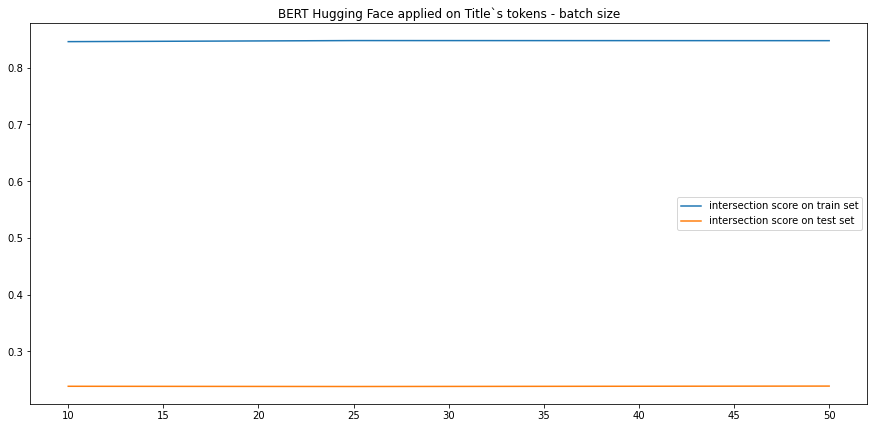

In [73]:
plt.figure('BERT HF logreg title, score=f(taille batch)', figsize=(15,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_title('BERT Hugging Face applied on Title`s tokens - batch size', fontsize=12)
batch_size, score_train, score_test = [], [], []
for i in range(len(tab_sauvegarde_berthf)):
    batch_size.append(tab_sauvegarde_berthf[i][0]), score_train.append(tab_sauvegarde_berthf[i][-2]), score_test.append(tab_sauvegarde_berthf[i][-1])
axe.plot(batch_size, score_train, label='intersection score on train set'), axe.plot(batch_size, score_test, label='intersection score on test set')
axe.legend(loc='best')
del axe, batch_size, score_train, score_test, i

### OK, la taille du batch n'influe donc - comme on le pensait - QUE sur la durée du calcul, on a donc intérêt à la prendre grande.

In [74]:
del tab_sauvegarde_berthf

###### 
### <u><b>III.4.b) Utilisation de ces features dans un MultiOutputClassifier.</b></u>
### Maintenant qu'on a créé des features avec cette technique de plongement de mots, on utilise un MultiOutputClassifier (combiné à des estimateurs de classifications) pour faire différentes séries de 5 prédiction par documents, et calculer des scores correspondants avec notre métrique personnelle.
### Comme précédemment, il nous faut d'abord extraire les features qui seront communes à tous nos estimateurs.

In [75]:
### Création des features de word embedding
feat_berthf, last_hidden_states_tot_berthf = feature_BERT_fct(
    model=transformers.TFAutoModel.from_pretrained('bert-base-uncased'), 
    model_type='bert-base-uncased', 
    sentences=sentences_bert_title, 
    max_length=tokens_title.apply(lambda x : len(x)).max(), 
    b_size=50, 
    mode='HF'
)
# division des features entre jeu d'entraînement et jeu de test
feat_berthf_train, feat_berthf_test = feat_berthf[lignes_train], feat_berthf[lignes_test]
del last_hidden_states_tot_berthf

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [110]:
if sauvegarde_fichiers :
    pickle_save(feat_berthf, 'feat_berthf')

In [307]:
# impression de la dimension de la matrice des features
print(feat_berthf.shape)

(13558, 768)


### On notera, à la différence de Word2Vec, que les dimensions de l'espace de plongements de mots (768) :
- n'ont pas été définies au préalable du calcul d'extraction de features ;
- sont plus grandes que celles de l'espace de plongement de mots issu de Word2Vec (du fait de notre choix de fixer cette valeur à 300), mais ~du même ordre de grandeur, ce qui rend notre choix de fixer le nombre de composantes issues de Word2Vec à 300 pertinent.

###### 
### <b><u>Avec un SVC().</u></b>

In [76]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_svc_berthf = MultiOutputClassifier(estimator=SVC(random_state=rgn), n_jobs=15)
    moc_svc_berthf.fit(feat_berthf_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_svc_berthf, 'moc_svc_berthf')
else :
    moc_svc_berthf = pickle_load('moc_svc_berthf')
# Prediction sur jeux train et test
Y_pred_train_svc_berthf, Y_pred_test_svc_berthf = moc_svc_berthf.predict(feat_berthf_train), moc_svc_berthf.predict(feat_berthf_test)
# Calculs d'intersection metric sur ces jeux
score_train_svc_berthf, score_test_svc_berthf = intersection_metric(Y_train, Y_pred_train_svc_berthf), intersection_metric(Y_test, Y_pred_test_svc_berthf)
print(f'Avec BERT HF, SVC, sur le corpus de Title :\n\t- score train = {score_train_svc_berthf:.02f}\n\t- score test = {score_test_svc_berthf:.02f}')

Avec BERT HF, SVC, sur le corpus de Title :
	- score train = 0.19
	- score test = 0.16


###### 
### <b><u>Avec un LogisticRegression()</u></b>

In [77]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_logreg_berthf = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
    moc_logreg_berthf.fit(feat_berthf_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_logreg_berthf, 'moc_logreg_berthf')
else :
    moc_logreg_berthf = pickle_load('moc_logreg_berthf')
# Prediction sur jeux train et test
Y_pred_train_logreg_berthf, Y_pred_test_logreg_berthf = moc_logreg_berthf.predict(feat_berthf_train), moc_logreg_berthf.predict(feat_berthf_test)
# Calculs d'intersection metric sur ces jeux
score_train_logreg_berthf, score_test_logreg_berthf = intersection_metric(Y_train, Y_pred_train_logreg_berthf), intersection_metric(Y_test, Y_pred_test_logreg_berthf)
print(f'Avec BERT HF, LogisticRegression, sur le corpus de Title :\n\t- score train = {score_train_logreg_berthf:.02f}\n\t- score test = {score_test_logreg_berthf:.02f}')

Avec BERT HF, LogisticRegression, sur le corpus de Title :
	- score train = 0.85
	- score test = 0.24


###### 
### <b><u>Avec un DecisionTreeClassifier()</u></b>

In [78]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_dtc_berthf = MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=10, random_state=rgn), n_jobs=15)
    moc_dtc_berthf.fit(feat_berthf_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_dtc_berthf, 'moc_dtc_berthf')
else :
    moc_dtc_berthf = pickle_load('moc_dtc_berthf')
# Prediction sur jeux train et test
Y_pred_train_dtc_berthf, Y_pred_test_dtc_berthf = moc_dtc_berthf.predict(feat_berthf_train), moc_dtc_berthf.predict(feat_berthf_test)
# Calculs d'intersection metric sur ces jeux
score_train_dtc_berthf, score_test_dtc_berthf = intersection_metric(Y_train, Y_pred_train_dtc_berthf), intersection_metric(Y_test, Y_pred_test_dtc_berthf)
print(f'Avec BERT HF, DecisionTreeC, sur le corpus de Title :\n\t- score train = {score_train_dtc_berthf:.02f}\n\t- score test = {score_test_dtc_berthf:.02f}')

Avec BERT HF, DecisionTreeC, sur le corpus de Title :
	- score train = 0.12
	- score test = 0.06


###### 
### <b><u>Avec un RandomForrestClassifier()</u></b>

In [79]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_rfc_berthf = MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50, max_depth=20, random_state=rgn), n_jobs=15)
    moc_rfc_berthf.fit(feat_berthf_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_rfc_berthf, 'moc_rfc_berthf')
else :
    moc_rfc_berthf = pickle_load('moc_rfc_berthf')
# Prediction sur jeux train et test
Y_pred_train_rfc_berthf, Y_pred_test_rfc_berthf = moc_rfc_berthf.predict(feat_berthf_train), moc_rfc_berthf.predict(feat_berthf_test)
# Calculs d'intersection metric sur ces jeux
score_train_rfc_berthf, score_test_rfc_berthf = intersection_metric(Y_train, Y_pred_train_rfc_berthf), intersection_metric(Y_test, Y_pred_test_rfc_berthf)
print(f'Avec BERT HF, RandomForrestClassifier, sur le corpus de Title :\n\t- score train = {score_train_rfc_berthf:.02f}\n\t- score test = {score_test_rfc_berthf:.02f}')

Avec BERT HF, RandomForrestClassifier, sur le corpus de Title :
	- score train = 0.54
	- score test = 0.09


### De nouveau, on déplore que le manque du temps (dû au retard pris sur le projet) nous fasse sauter l'optimisation des différents hyper-paramètres de ces estimateurs...
### Tous les scores ainsi calculés seront comparés en fin de notebook, en même temps que ceux issus de Word2Vec.

## 
## <b><u>III.5) Utilisation de USE.</u></b>
### On reprend ici énormément de lignes de codes telles que présentées dans le notebook d'analyse des tweets, donné dans la page de présentation du projet (https://openclassrooms.com/fr/paths/148/projects/111/assignment), afin de ne pas perdre trop de temps avec l'exploration des librairies python corrspondantes.

### <b><u>NB :</u></b> Ci-dessous, on a besoin de charger à distance un modèle de TensorFlow Hub (contenu dans la variable <i>embed</i>). Par défaut, cela l'envoie dans un répertoire créé automatiquement en local (chez moi : <b>C:/Users/luked/AppData/Local/Temp/tfhub_modules/063d866c06683311b44b4992fd46003be952409c/</b>), MAIS les fichiers contenus ne sont présents que TEMPORAIREMENT, le temps du maintien en activité de ce notebook !!! 

### Si on cherche à relancer le notebook (du moins après avoir fermé le terminal ayant conduit à son lancement), il faut aller supprimer le répertoire contenant ce module (chez moi : <b>/063d866c06683311b44b4992fd46003be952409c/</b>) pour pouvoir relancer le chargement sans signal d'erreur.

In [80]:
# De nouveau, on transformes les listes de tokens en chaînes entières de caractère pour correspondre au format de données d'entrées attendues par la fonction d'extraction de features
sentences_use_title = tokens_title.apply(lambda x : tokens_to_string(x)).values
# embed est présent dans la fonction de génération de features
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")#C:/Users/luked/AppData/Local/Temp/tfhub_modules/")#

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:42:42<00:00, 2054.29s/it]


###### 
### <u><b>III.5.a) Test de la dépendance à la taille du <i>batch</i>.</b></u>
### Malgré notre expérience précédente, on préfère de nouveau tester l'impact de la taille du <i>batch</i> sur les capacités de prédéctions de ce modèle

In [81]:
# Initialisation du tableau dans lequel on va sauvegarder les données calculées :
tab_sauvegarde_use = []
pbar = tqdm.tqdm(total=len([10,25,50]))
for batch_size in [10,25,50]:
    ### Création des features de word embedding
    feat_use = feature_USE_fct(sentences_use_title, batch_size)
    # Séparation entraînement/test
    feat_use_train, feat_use_test = feat_use[lignes_train], feat_use[lignes_test]
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
    moc.fit(feat_use_train, Y_train)
    # Prediction sur jeux train et test
    Y_pred_train, Y_pred_test = moc.predict(feat_use_train), moc.predict(feat_use_test)
    pbar.update(1)
    # Calculs d'intersection metric sur ces jeux
    score_train, score_test = intersection_metric(Y_train, Y_pred_train), intersection_metric(Y_test, Y_pred_test)
    # Sauvegarde
    tab_sauvegarde_use.append([batch_size, feat_use_train, feat_use_test, moc, Y_pred_train, Y_pred_test, score_train, score_test])
    print(f'Avec batch_size={batch_size}, on a score_train={score_train:.2f}, score_test={score_test:.2f}')
    del feat_use, feat_use_train, feat_use_test, moc, Y_pred_train, Y_pred_test, score_train, score_test
del pbar

 33%|███████████████████████████▋                                                       | 1/3 [03:32<07:05, 212.66s/it]

Avec batch_size=10, on a score_train=0.35, score_test=0.30


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [06:51<03:24, 204.74s/it]

Avec batch_size=25, on a score_train=0.35, score_test=0.30


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [10:07<00:00, 200.72s/it]

Avec batch_size=50, on a score_train=0.35, score_test=0.30


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [10:08<00:00, 202.67s/it]


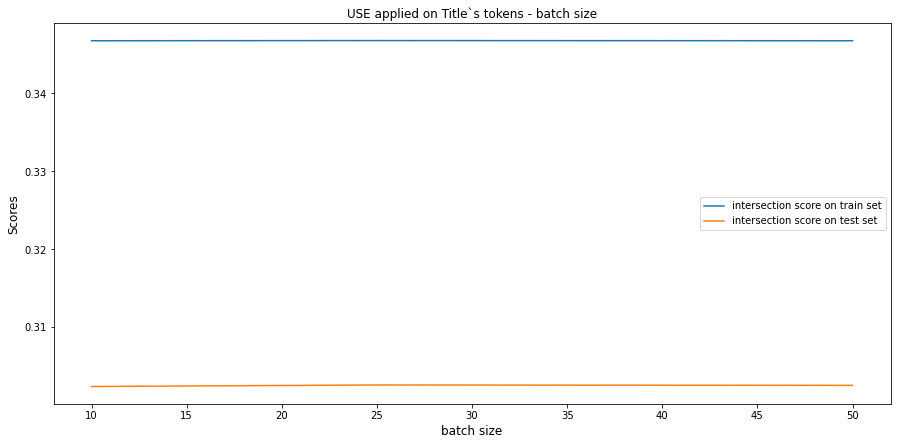

In [82]:
plt.figure('USE logreg title, score=f(taille batch)', figsize=(15,7)), plt.clf()
axe = plt.subplot(1,1,1)
axe.set_title('USE applied on Title`s tokens - batch size', fontsize=12)
axe.set_ylabel('Scores', fontsize=12), axe.set_xlabel('batch size', fontsize=12)
batch_size, score_train, score_test = [], [], []
for i in range(len(tab_sauvegarde_use)):
    batch_size.append(tab_sauvegarde_use[i][0]), score_train.append(tab_sauvegarde_use[i][-2]), score_test.append(tab_sauvegarde_use[i][-1])
axe.plot(batch_size, score_train, label='intersection score on train set'), axe.plot(batch_size, score_test, label='intersection score on test set')
axe.legend(loc='best')
del axe, batch_size, score_train, score_test, i

### Parfait, de nouveau la taille du batch n'influe QUE sur la vitesse d'exécution, comme c'est prévu pour.

In [83]:
del tab_sauvegarde_use

###### 
### <u><b>III.5.b) Utilisation de ces features dans un MultiOutputClassifier.</b></u>
### Maintenant qu'on a créé des features avec cette technique de plongement de mots, on utilise un MultiOutputClassifier (combiné à des estimateurs de classifications) pour faire différentes séries de 5 prédiction par documents, et calculer des scores correspondants avec notre métrique personnelle.
### Comme précédemment, il nous faut d'abord extraire les features qui seront communes à tous nos estimateurs.

In [84]:
# génération de features
feat_use = feature_USE_fct(sentences_use_title, 100)
# Séparation entraînement/test
feat_use_train, feat_use_test = feat_use[lignes_train], feat_use[lignes_test]

In [111]:
if sauvegarde_fichiers :
    pickle_save(feat_use,'feat_use')

In [308]:
print(feat_use.shape)

(13558, 512)


### On notera de nouveau, à la différence de Word2Vec et comme pour BERT, que les dimensions de l'espace de plongements de mots (512) :
- n'ont pas été définies au préalable du calcul d'extraction de features ;
- sont plus grandes que celles de l'espace de plongement de mots issu de Word2Vec (du fait de notre choix de fixer cette valeur à 300), mais ~du même ordre de grandeur, ce qui rend notre choix de fixer le nombre de composantes issues de Word2Vec à 300 pertinent ;
- sont néanmoins un peu moins grandes que dans le cas de BERT HuggingFace.

###### 
### <b><u>Avec un LogisticRegression()</u></b>

In [85]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_logreg_use = MultiOutputClassifier(estimator=LogisticRegression(random_state=rgn), n_jobs=15)
    moc_logreg_use.fit(feat_use_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_logreg_use, 'moc_logreg_use')
else :
    moc_logreg_use = pickle_load('moc_logreg_use')
# Prediction sur jeux train et test
Y_pred_train_logreg_use, Y_pred_test_logreg_use = moc_logreg_use.predict(feat_use_train), moc_logreg_use.predict(feat_use_test)
# Calculs d'intersection metric sur ces jeux
score_train_logreg_use, score_test_logreg_use = intersection_metric(Y_train, Y_pred_train_logreg_use), intersection_metric(Y_test, Y_pred_test_logreg_use)
print(f'Avec USE, LogisticRegression, sur le corpus de Title :\n\t- score train = {score_train_logreg_use:.02f}\n\t- score test = {score_test_logreg_use:.02f}')

Avec USE, LogisticRegression, sur le corpus de Title :
	- score train = 0.35
	- score test = 0.30


###### 
### <b><u>Avec un SVC()</u></b>

In [86]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_svc_use = MultiOutputClassifier(estimator=SVC(random_state=rgn), n_jobs=15)
    moc_svc_use.fit(feat_use_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_svc_use, 'moc_svc_use')
else :
    moc_svc_use = pickle_load('moc_svc_use')
# Prediction sur jeux train et test
Y_pred_train_svc_use, Y_pred_test_svc_use = moc_svc_use.predict(feat_use_train), moc_svc_use.predict(feat_use_test)
# Calculs d'intersection metric sur ces jeux
score_train_svc_use, score_test_svc_use = intersection_metric(Y_train, Y_pred_train_svc_use), intersection_metric(Y_test, Y_pred_test_svc_use)
print(f'Avec USE, SVC, sur le corpus de Title :\n\t- score train = {score_train_svc_use:.02f}\n\t- score test = {score_test_svc_use:.02f}')

Avec USE, SVC, sur le corpus de Title :
	- score train = 0.54
	- score test = 0.32


###### 
### <b><u>Avec un DecisionTreeClassifier()</u></b>

In [87]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_dtc_use = MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=10, random_state=rgn), n_jobs=15)
    moc_dtc_use.fit(feat_use_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_dtc_use, 'moc_dtc_use')
else :
    moc_dtc_use = pickle_load('moc_dtc_use')
# Prediction sur jeux train et test
Y_pred_train_dtc_use, Y_pred_test_dtc_use = moc_dtc_use.predict(feat_use_train), moc_dtc_use.predict(feat_use_test)
# Calculs d'intersection metric sur ces jeux
score_train_dtc_use, score_test_dtc_use = intersection_metric(Y_train, Y_pred_train_dtc_use), intersection_metric(Y_test, Y_pred_test_dtc_use)
print(f'Avec USE, DecisionTreeC, sur le corpus de Title :\n\t- score train = {score_train_dtc_use:.02f}\n\t- score test = {score_test_dtc_use:.02f}')

Avec USE, DecisionTreeC, sur le corpus de Title :
	- score train = 0.25
	- score test = 0.17


###### 
### <b><u>Avec une RandomForrestClassifier()</u></b>

In [89]:
if court_circuiter == False :
    pbar = tqdm.tqdm(total=1)
    ### Classsification multi output (ici avec une régression logistique, empririquement la + rapide)
    moc_rfc_use = MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50, max_depth=20, random_state=rgn), n_jobs=15)
    moc_rfc_use.fit(feat_use_train, Y_train)
    pbar.update(1)
    del pbar
    if sauvegarde_fichiers :
        pickle_save(moc_rfc_use, 'moc_rfc_use')
else :
    moc_rfc_use = pickle_load('moc_rfc_use')
# Prediction sur jeux train et test
Y_pred_train_rfc_use, Y_pred_test_rfc_use = moc_rfc_use.predict(feat_use_train), moc_rfc_use.predict(feat_use_test)
# Calculs d'intersection metric sur ces jeux
score_train_rfc_use, score_test_rfc_use = intersection_metric(Y_train, Y_pred_train_rfc_use), intersection_metric(Y_test, Y_pred_test_rfc_use)
print(f'Avec USE, RandomForrestClassifier, sur le corpus de Title :\n\t- score train = {score_train_rfc_use:.02f}\n\t- score test = {score_test_rfc_use:.02f}')

Avec USE, RandomForrestClassifier, sur le corpus de Title :
	- score train = 0.78
	- score test = 0.25


######  
## <b><u>III.6) Comparaison.</u></b>
### On va enfin faire la comparaison des modèles pour l'approche supervisée, grâce aux différents scores calculés tout au long de cette section.
### Notons que les résultats issus des DecisionTreeClassifier ne sont pas présentés, puisqu'on a travaillé dans la foulée sur des RandomForrestClassifier plus profondes.

In [90]:
# on range ces scores dans ce tableau pour nous faciliter le travail à venir
tab_scores = np.array([
    [score_train_svc_w2v, score_test_svc_w2v], [score_train_logreg_w2v, score_test_logreg_w2v], [score_train_rfc_w2v, score_test_rfc_w2v], 
    [score_train_svc_berthf, score_test_svc_berthf], [score_train_logreg_berthf, score_test_logreg_berthf], [score_train_rfc_berthf, score_test_rfc_berthf], 
    [score_train_svc_use, score_test_svc_use], [score_train_logreg_use, score_test_logreg_use], [score_train_rfc_use, score_test_rfc_use], 
])

### On affiche les évolutions des scores sur les jeux d'entraînement, et de test.

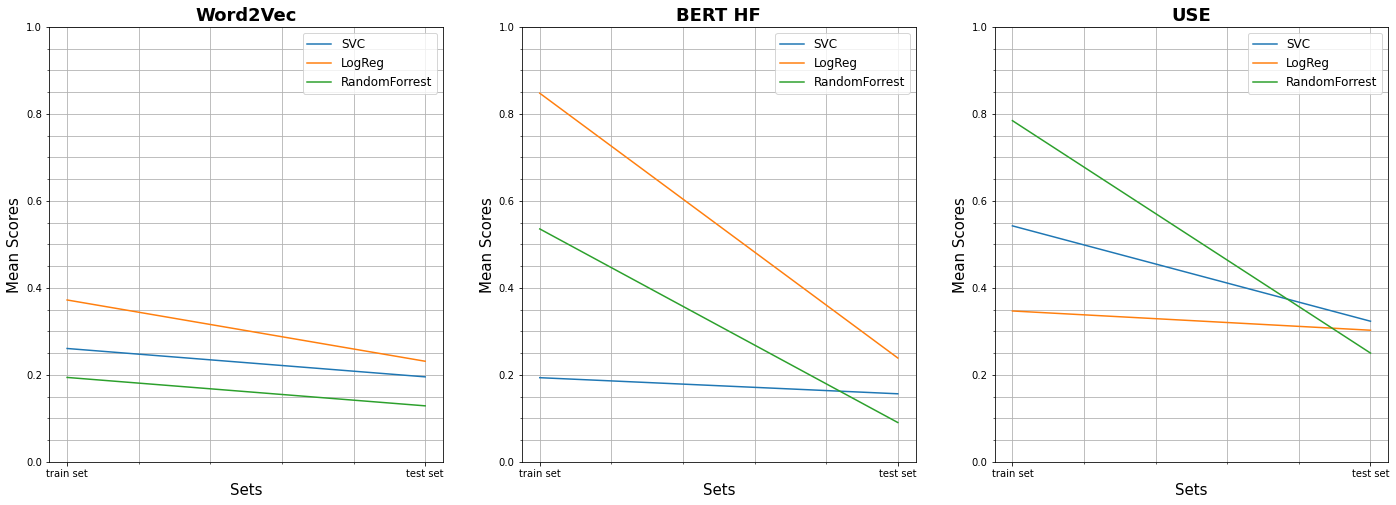

In [91]:
plt.figure('comparaison approche supervisee', figsize=(24,8)), plt.clf()
for i, approche in enumerate(['Word2Vec', 'BERT HF', 'USE']) :
    axe = plt.subplot(1,3,i+1)
    axe.set_title(label=approche, fontsize=18, fontweight='bold'), axe.set_ylim([0,1]), axe.minorticks_on(), axe.grid(which='both')
    for j, scores in enumerate(tab_scores[i*3:i*3+3]):
        axe.plot(['train set', 'test set'], 
                 [scores[0], scores[1]], 
                 label=['SVC','LogReg','RandomForrest'][j])
    axe.legend(loc='best', fontsize=12), axe.set_ylabel('Mean Scores', fontsize=15), axe.set_xlabel('Sets', fontsize=15)
del i, approche, j, scores, axe

### Que constate t'on ?
### 1) Assez régulièrement, on a du sur-apprentissage.
### 2) Globalement, les scores sont médiocres, particulièrement sur les jeu de test, et même les scores sur jeu d'entraînement ne sont pas si élevés que ça dans la plupart des cas. C'est peut être dû au fait qu'on a utilisé un jeu d'entraînement de taille "modeste" (70% du jeu de données, et non 80 ou 90).
### 3) Word2Vec conduit à des scores trop peu supérieurs à ceux obtenus avec la baseline, c'est très décevant.

### Maintenant, notre meilleure modèle, au sens du score sur le jeu de test est {features extraites avec USE + MultiOutputClassifier + SVC}. <b>Cependant, on préfèrera prendre le modèle{features extraites avec USE + MultiOutputClassifier + LogisticRegression} car, pour un score sur jeu de test à peine moins bon, ce modèle permets des calculs plus rapide que le précédent (on l'a constaté), ce qui est un avantage non négligeable.</b>

######  
## <b><u>III.7) Analyse des prédictions de ce modèle.</u></b>
### Comparons, via un pandas.Dataframe les vraies étiquettes du jeu de test, ainsi que les prédictions issues de ce meilleur modèle.

In [359]:
df_comp_opt = pd.DataFrame(dict({f'Tag {n+1}':Y_test[:,n] for n in range(5)}, **{f'Pred {n+1}':Y_pred_test_logreg_use[:,n] for n in range(5)}), index=lignes_test)
# affichage
df_comp_opt

,Tag 1,Tag 2,Tag 3,Tag 4,Tag 5,Pred 1,Pred 2,Pred 3,Pred 4,Pred 5
10917,git,github,mercurial,bitbucket,atlassian-sourcetree,git,github,version-control,npm,bundler
10890,python,image-processing,numpy,scipy,python-imaging-library,python,arrays,numpy,numpy,numpy-ndarray
6326,java,junit,annotations,junit4,junit5,java,spring,spring-boot,annotations,terminology
750,python,function,nested,closures,nested-function,python,python-3.x,python-3.x,methods,python-internals
864,c++,c,math,statistics,distribution,c,c,tsql,c++11,c++-faq
...,...,...,...,...,...,...,...,...,...,...
9372,python,machine-learning,neural-network,tensorflow,conv-neural-network,python,numpy,numpy,numpy,numpy-ndarray
1862,ruby-on-rails,ruby,localization,rails-i18n,strftime,ruby-on-rails,ruby,datetime,datetime,utc
3388,c#,asp.net-mvc,razor,asp.net-mvc-4,partial-views,c#,asp.net-mvc,asp.net-mvc,asp.net-mvc-4,razor
6270,statistics,physics,probability,error-detection,risk-analysis,python,c,numpy,dataframe,r-faq


### On constate que sur certaines lignes du jeu de test (par exemple ci dessus : 10890, 750, 864, 9372 etc) qu'on n'a pas systématiquement 5 prédictions uniques par documents !!! Or c'est un Problème qui pourrait altérer les scores calculés plus haut !!!
### Comptons combien de lignes du jeu de test conduisent à moins de 5 prédictions uniques :

In [365]:
# on crée une série qui contient le nombre de prédictions uniques pour chaque document du jeu de test
nb_pred_unique_test = pd.Series([len(np.unique(x)) for x in Y_pred_test_logreg_use], index=lignes_test)
# Affichage du décompte de ces nombres
nb_pred_unique_test.value_counts()

4    1837
5    1820
3     404
2       7
dtype: int64

### Un peu plus de la moitié de jeu de test conduit à moins de 5 prédictions uniques.
### Pour corriger cela, on a produit une version personnelle de la fonction de prédictions, qui, lorsqu'elle détecte une prédiction non uniques, choisit le second mot le plus probable en guise de prédiction, puis le 3ème si le 2nd a déjà été prédit une fois dans la liste des prédictions, et ainsi de suite jusq'à obtenir enfin une prédiction authentiquement nouvelle.
### Ci-dessous : on recrée un vecteur de liste de 5 rédictions uniques (avec cette nouvelle fonction), pour les lignes du jeu de test qui conduisaient initialement à moins de 5 prédictions uniques.

In [366]:
nouv_pred_uniques = predire_tags_uniques(moc_logreg_use, feat_use[nb_pred_unique_test[nb_pred_unique_test<5].index.values])

### On refait la comparaison avec les lignes de Y_test correspondantes 

In [393]:
y_test_restreint = Y_test[np.array([True if ligne in nb_pred_unique_test[nb_pred_unique_test<5].index.values else False for ligne in lignes_test])]
# Affichage sous forme de dataframe
pd.DataFrame(
    data = dict(
        {f'Tag {n+1}':y_test_restreint[:,n] for n in range(5)}, 
        **{f'Pred {n+1}':np.array(nouv_pred_uniques)[:,n] for n in range(5)}), 
    index=lignes_test[np.array([True if ligne in nb_pred_unique_test[nb_pred_unique_test<5].index.values else False for ligne in lignes_test])])

,Tag 1,Tag 2,Tag 3,Tag 4,Tag 5,Pred 1,Pred 2,Pred 3,Pred 4,Pred 5
10890,python,image-processing,numpy,scipy,python-imaging-library,python,arrays,numpy,dataframe,numpy-ndarray
750,python,function,nested,closures,nested-function,python,python-3.x,oop,methods,python-internals
864,c++,c,math,statistics,distribution,c,algorithm,tsql,c++11,c++-faq
12955,performance,haskell,ghc,higher-order-functions,lambda-calculus,c++,performance,c++11,functional-programming,c++-faq
4812,c++,c,optimization,execution-time,as-if,c++,performance,tsql,datetime,task-parallel-library
...,...,...,...,...,...,...,...,...,...,...
2259,svn,git,version-control,mercurial,bazaar,git,linux,version-control,c++-faq,abi
10333,php,rest,curl,put,http-put,php,http,rest,https,cors
9372,python,machine-learning,neural-network,tensorflow,conv-neural-network,python,numpy,dataframe,deep-learning,numpy-ndarray
1862,ruby-on-rails,ruby,localization,rails-i18n,strftime,ruby-on-rails,ruby,datetime,time,utc


### C'est mieux, mais à vue d'oeil, les nouvelles prédictions n'ont pas l'air cependant de générer plus de bonne réponses que les anciennes, malgré leur unicité cette fois assurée.
### Calculons le score sur ces lignes du jeu de test, avec les nouvelles prédictions :

In [386]:
intersection_metric(Y_test[np.array([True if ligne in nb_pred_unique_test[nb_pred_unique_test<5].index.values else False for ligne in lignes_test])], 
                    nouv_pred_uniques)

0.3451067615658363

### Alors qu'avec les anciennes prédictions non uniques :

In [387]:
intersection_metric(Y_test[np.array([True if ligne in nb_pred_unique_test[nb_pred_unique_test<5].index.values else False for ligne in lignes_test])], 
                    Y_pred_test_logreg_use[np.array([True if ligne in nb_pred_unique_test[nb_pred_unique_test<5].index.values else False for ligne in lignes_test])])

0.3082740213523132

### Autrement dit, le score n'en est amélioré que de ~10%, ce qui est mieux mais peu, sachant que les lignes en questions ne représentent que la moitiée du jeu de test (pour l'autre moitié, on avait déjà unicité des 5 prédictions), ce qui nuance cette amélioration...
### Conclusion : il n'y a pas de raison de penser qu'il faille absolument refaire toutes les prédictions avec cette nouvelle fonction sur tous les modèles, car les améliorations de scores en serait presque insignificatives. <i>Donc on peut conserver ce modèle comme modèle optimal</i>

# 
# <u><b>IV) Modèle final retenu.</b></u>
### Malgré les faibles scores, on retient le modèle optimal précédent issu de l'approche supervisée, plutôt qu'un modèle issue de l'approche non supervisée. Pourquoi ? Car malgré son mauvais score, il est plus facile à transposer rapidement sous la forme d'une API, ET ses prédictions sont directement comparables aux <i>tags</i> réels déjà suggérés. 